# Análise de Concessão de Crédito
###Professor: Germano Vasconcelos


---


Alunos:
<br>
Felipe Jun Ting Lin - fjtl2@cin.ufpe.br
<br>
João Gabriel Vasconcelos - jgav@cin.ufpe.br
<br>
Maria Eduarda Mota - mebm@cin.ufpe.br
<br>
Rafael Bernardo Nunes Neto - rbnn@cin.ufpe.br

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
%pip install xlrd
%pip install torchsummary 
%pip install optuna
%pip install scikit-plot
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchsummary import summary
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import make_scorer, roc_auc_score, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score
from sklearn.datasets import make_blobs
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import VotingClassifier
from scipy.stats import ks_2samp
from tqdm import tqdm
import optuna
import scikitplot as skplt
import io
import os

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Análise e Preparação dos Dados

In [4]:
df = pd.read_table('TRNcod.xls')
df.head()

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,0,1,1,1,0,0,0,0,0.135098,1,...,0,0,1,1,0,1,1,1,0,1
1,1,1,0,1,0,0,1,0,0.273504,1,...,0,1,0,1,1,0,0,0,1,0
2,2,1,0,1,0,0,1,0,0.281910,0,...,1,1,0,0,0,0,1,0,1,0
3,3,1,1,1,0,0,0,0,0.225741,0,...,1,1,0,1,1,0,1,0,1,0
4,4,1,1,0,0,0,1,0,0.480403,0,...,1,1,1,0,0,1,0,1,1,0


Analisamos, a título de conhecimento, os valores não inteiros do banco de dados.

In [5]:
# Definimos a função para chegar se o valor é inteiro
def is_integer(val):
    #if (val % 1 == 0):
    #    return True
    #else:
    #    return False
    return True if isinstance(val, int) else False

for column in df:
  integer_mask = df[column].apply(is_integer)
  # Checa se algum elemento da coluna é inteiro
  has_integers = integer_mask.any()

  # Printa o elemento não inteiro da coluna
  if not has_integers:
      print(f"A coluna {column} não possui valores inteiros.")
      print(f"Um exemplo de valor é {df[column][0]}.")    

  # Printa se há elementos com valoração maiores que 10
  if max(df[column]) > 10:
    print(f"A coluna {column} possuí valor(es) maior(es) que 10.")

A coluna INDEX possuí valor(es) maior(es) que 10.
A coluna IDADE não possui valores inteiros.
Um exemplo de valor é 0.135097920813897.
A coluna NIVEL_RELACIONAMENTO_CREDITO01 não possui valores inteiros.
Um exemplo de valor é 0.222222222222222.
A coluna NIVEL_RELACIONAMENTO_CREDITO02 não possui valores inteiros.
Um exemplo de valor é 0.0.
A coluna ATIVIDADE_EMAIL não possui valores inteiros.
Um exemplo de valor é 5.88123507740785e-18.
A coluna EXPOSICAO_ENDERECO não possui valores inteiros.
Um exemplo de valor é 0.0416666666666667.
A coluna EXPOSICAO_EMAIL não possui valores inteiros.
Um exemplo de valor é 0.0.
A coluna EXPOSICAO_TELEFONE não possui valores inteiros.
Um exemplo de valor é 0.0.
A coluna ATIVIDADE_ENDERECO não possui valores inteiros.
Um exemplo de valor é 0.1055877023706.
A coluna ATUALIZACAO_ENDERECO não possui valores inteiros.
Um exemplo de valor é 0.796392205503436.
A coluna ATUALIZACAO_EMAIL não possui valores inteiros.
Um exemplo de valor é -5.14095849300494e-17.


Primeiramente, checamos por duplicatas no código.

In [6]:
df[df.duplicated(keep=False)]

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2


In [7]:
df.dtypes

INDEX          int64
UF_1           int64
UF_2           int64
UF_3           int64
UF_4           int64
               ...  
CEP4_12        int64
CEP4_13        int64
CEP4_14        int64
IND_BOM_1_1    int64
IND_BOM_1_2    int64
Length: 246, dtype: object

In [8]:
df.describe()

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
count,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,3.891960e+05,389196.000000,...,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000
mean,194597.500000,0.889274,0.691952,0.476552,0.296195,0.241179,0.218011,0.186836,4.552049e-01,0.521514,...,0.423378,0.417540,0.425708,0.459820,0.440842,0.436896,0.433709,0.440339,0.655449,0.344551
std,112351.352021,0.313793,0.461687,0.499451,0.456579,0.427799,0.412895,0.389781,2.537459e-01,0.499538,...,0.494095,0.493154,0.494451,0.498384,0.496489,0.496002,0.495587,0.496428,0.475222,0.475222
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.506237e-16,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,97298.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.507866e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,194597.500000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.375241e-01,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,291896.250000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,6.578835e-01,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,389195.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Como os parâmetros 'IND_BOM_1_1' e 'IND_BOM_1_2' são indicadores do mesmo dado, podemos trabalhar apenas com um deles. Para a nossa análise, escolhemos 'IND_BOM_1_2'.

In [9]:
df['IND_BOM_1_1'].value_counts()

1    255098
0    134098
Name: IND_BOM_1_1, dtype: int64

In [10]:
df['IND_BOM_1_2'].value_counts()

0    255098
1    134098
Name: IND_BOM_1_2, dtype: int64

In [11]:
# Vemos aqui que não possuímos 'IND_BOM_1_1' e 'IND_BOM_1_2' com valores iguais para uma mesma instância
df.loc[((df['IND_BOM_1_1'] == 0) & ( df['IND_BOM_1_2'] == 0)) | ((df['IND_BOM_1_1'] == 1) & ( df['IND_BOM_1_2'] == 1))].count()[0] 

0

Como podemos ver no plot a seguir, há uma distribuição desigual das instâncias no referente ao parâmetro de concessão de crédito.

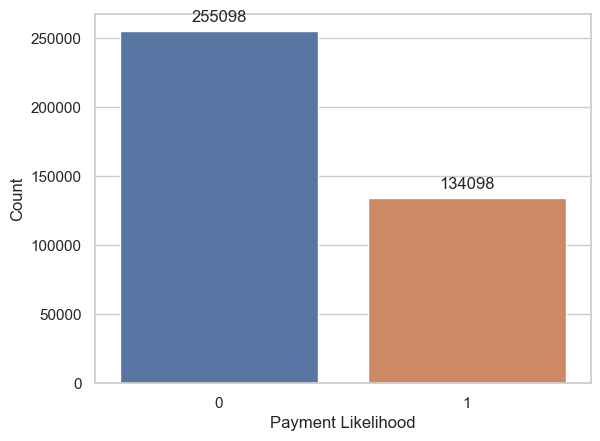

In [12]:
sns.set_theme(style="whitegrid")
title="Penguin species exhibit distinct bill shapes"
ax = sns.countplot(data=df, x='IND_BOM_1_2')
ax.set(xlabel='Payment Likelihood', ylabel='Count')
for p in ax.patches:
  ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

Fazemos uma separação das instâncias com valor do parâmetro analisado.

In [13]:
dfMinor = df[df['IND_BOM_1_2']==1]
dfMajor = df[df['IND_BOM_1_2']==0]

### Set de Treino e Validação

Separamos os dados em set treino e validação em uma proporação de 70% para 30%, respectivamente (segmentando o target 'IND_BOM_1_2' e removendo o parâmetro 'IND_BOM_1_1' que é redundante). Como pretendemos fazer uma mistura dos dados Major e Minor, posteriormente, mantemos o target label no dataset X.

In [14]:
data_train_minor, data_val_minor, _, _ = train_test_split(dfMinor, dfMinor['IND_BOM_1_2'], test_size=0.33, random_state=42)

In [15]:
print(data_train_minor.shape)

(89845, 246)


In [16]:
print(data_val_minor.shape)

(44253, 246)


In [17]:
data_train_major, data_val_major, _, _ = train_test_split(dfMajor, dfMajor['IND_BOM_1_2'], test_size=0.33, random_state=42)

In [18]:
print(data_train_major.shape)

(170915, 246)


In [19]:
print(data_val_major.shape)

(84183, 246)


### Oversampling

Visto que possuímos uma distribuição desigual de dados por classe, fazemos uma repopulação de instâncias de treino X_train_major até que a quantidade seja equivalente a X_train_minor (Fazemos uma concatenação simples).

In [20]:
difference_train = data_train_major.shape[0] - data_train_minor.shape[0]
difference_train

81070

In [21]:
data_train_minor_sampled = pd.concat([data_train_minor, data_train_minor[:difference_train]])

In [22]:
data_train_minor_sampled.shape

(170915, 246)

In [23]:
data_train_minor_sampled.shape == data_train_major.shape

True

In [24]:
difference_val = data_val_major.shape[0] - data_val_minor.shape[0]
difference_val

39930

In [25]:
data_val_minor_sampled = pd.concat([data_val_minor, data_val_minor[:difference_val]])

In [26]:
data_val_minor_sampled.shape

(84183, 246)

In [27]:
data_val_minor_sampled.shape == data_val_major.shape

True

### Concatenação e Randomização dos Dados 

In [28]:
data_train = pd.concat([data_train_minor_sampled, data_train_major]).sample(frac=1, random_state=42).reset_index(drop=True)

In [29]:
data_train.shape

(341830, 246)

In [30]:
data_train.head(5)

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,288589,1,1,0,0,0,0,1,1.000000,0,...,0,0,0,1,1,1,0,1,1,0
1,191828,1,1,0,0,0,1,0,0.816508,0,...,0,0,0,1,1,0,0,0,1,0
2,364983,1,0,0,1,0,0,1,0.438603,0,...,0,0,0,1,0,1,0,1,0,1
3,200911,1,1,1,0,0,0,0,0.578145,1,...,0,0,1,0,1,1,0,0,0,1
4,151300,1,1,0,0,1,0,0,0.639880,1,...,0,1,1,0,0,0,0,1,0,1


In [31]:
data_val = pd.concat([data_val_minor_sampled, data_val_major]).sample(frac=1, random_state=42).reset_index(drop=True)

In [32]:
data_val.shape

(168366, 246)

In [33]:
data_val.head(5)

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,241985,1,0,0,1,1,0,0,0.469215,1,...,0,1,1,0,0,1,0,1,1,0
1,133371,1,0,0,1,1,0,0,0.220175,0,...,1,1,1,0,0,0,0,0,1,0
2,188775,1,1,1,0,0,0,0,0.682134,1,...,0,1,0,1,1,1,0,0,0,1
3,67904,1,1,1,0,0,0,0,0.118401,0,...,0,0,0,1,1,0,1,0,0,1
4,69261,1,1,0,1,0,0,0,0.627045,1,...,1,1,0,0,0,0,1,0,1,0


In [34]:
# Dropping the Index column
data_train = data_train.drop(columns=["INDEX", "IND_BOM_1_1"])
data_val = data_val.drop(columns=["INDEX", "IND_BOM_1_1"])

<AxesSubplot: xlabel='IND_BOM_1_2', ylabel='count'>

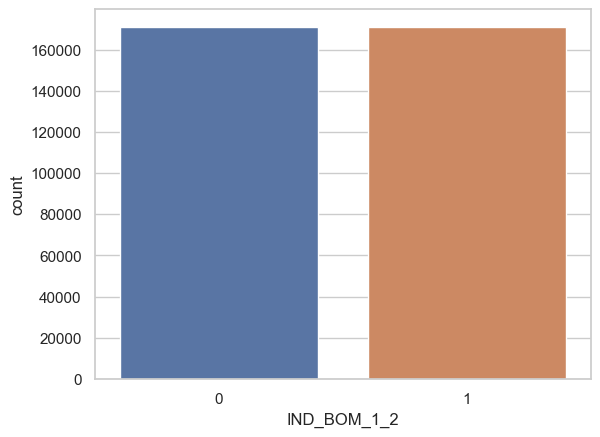

In [35]:
sns.countplot(x=data_train['IND_BOM_1_2'])

<AxesSubplot: xlabel='IND_BOM_1_2', ylabel='count'>

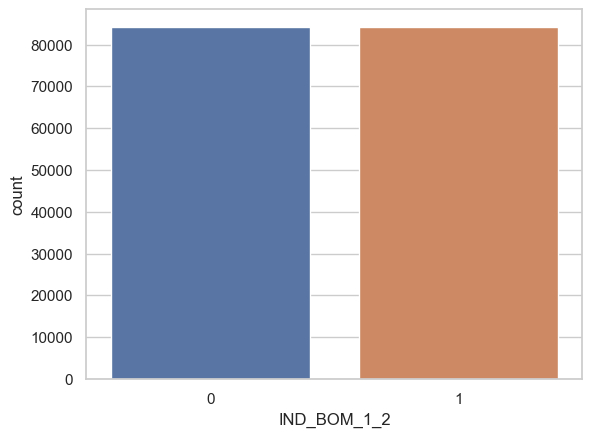

In [36]:
sns.countplot(x=data_val['IND_BOM_1_2'])

Possuimos, agora, dados balanceados tanto no treino quanto na validação.

### Normalização dos Dados

In [37]:
def scaler(data):
  return (data - data.min())/(data.max() - data.min())

In [38]:
def inverse_scaler(scaled_data, original_data):
  return scaled_data * (original_data.max() - original_data.min()) + original_data.min() 

In [39]:
normalized_train=scaler(data_train)
normalized_val=scaler(data_val)

Como após a normalização, alguns dados ficaram com valores NaN, dessa forma, vamos preencher esses dados com 0, tanto no dataset de treino, quanto no de validação.

In [40]:
for i in normalized_train.columns:
  if(normalized_train[i].isnull().values.any()):
    normalized_train[i] = normalized_train[i].fillna(0)
  if(normalized_val[i].isnull().values.any()):
    normalized_val[i] = normalized_val[i].fillna(0)

In [41]:
(normalized_train >= 0).all().any() and (normalized_val >= 0).all().any()

True

Trabalhamos com nossos dados base em numpy.

In [42]:
train_numpy = normalized_train.to_numpy()
val_numpy = normalized_val.to_numpy()
print(f'Our train data has shape: {train_numpy.shape}. Our validation data has shape: {val_numpy.shape}')

Our train data has shape: (341830, 244). Our validation data has shape: (168366, 244)


#### Funções Auxiliares

In [43]:
# Mean Squared Error
def mean_squared_error(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

In [44]:
# Função de Plot
def model_evaluation(history):
  figure = plt.figure(figsize=(5,3))

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc = 'upper left')
  plt.show()

## Definindo alguns paramêtros padrões para os modelos como por exemplo, epoch e learning_rate

In [45]:
EPOCHS = 10000
LEARNING_RATE = 0.001

## Aux plot function

In [46]:
# Criamos uma função para lidar com a estatística do KS Test

In [47]:
def ks_results(y_true, y_pred):
  return ks_2samp(y_pred[y_true == 1], y_pred[y_true != 1]).statistic

In [48]:
# Criamos uma função que retorna as entradas em numpy com o shape correto (-1,1) para saída

In [49]:
def reshape_plot(y_hat, y_true):
  print(f'type of y_hat: {type(y_hat)}, type of y_true: {type(y_true)}')
  if not isinstance(y_hat, np.ndarray):
    y_hat = y_hat.to_numpy(dtype=np.float32)
  if not isinstance(y_true, np.ndarray):
    y_true = y_true.to_numpy(dtype=np.float32)

  return y_hat.round().reshape(-1,1), y_true.reshape(-1,1)

In [50]:
# Criamos uma função para plotar a variação de métricas

In [51]:
def historyPlot(model, history_dict, x, y, isMLP = False):
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  accuracy = history_dict['accuracy']
  val_accuracy = history_dict['accuracy']
  
  epochs = range(1, len(loss_values) + 1)
  fig, ax = plt.subplots(1, 2, figsize=(14, 6))

  ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  ax[0].set_title('Training & Validation Accuracy', fontsize=16)
  ax[0].set_xlabel('Epochs', fontsize=16)
  ax[0].set_ylabel('Accuracy', fontsize=16)
  ax[0].legend()

  ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
  ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
  ax[1].set_title('Training & Validation Loss', fontsize=16)
  ax[1].set_xlabel('Epochs', fontsize=16)
  ax[1].set_ylabel('Loss', fontsize=16)
  ax[1].legend()
  
  testePlot(model, x, y, isMLP)

In [52]:
# Criamos uma função para exibir um estudo/plot desccritivo da accuracy, loss e ks statistic

In [53]:
def testePlot(model, x, y, isMLP = False):

  print(f'Gerando análises para o modelo {model}')
  y_pred = model.predict(x)
  y_pred = np.array([0 if x < 0.5 else 1 for x in y_pred])

  if isMLP:
    y_pred_score = model.predict(x)
    print(y_pred_score)
    y_pred_score_0 = 1 - y_pred_score
    y_pred_score = np.concatenate([y_pred_score_0, y_pred_score], axis = 1)
  else:
    y_pred_score = model.predict_proba(x)

  accuracy = accuracy_score(y, y_pred)
  recall = recall_score(y, y_pred)
  precision = precision_score(y, y_pred)
  f1 = f1_score(y, y_pred)
  skplt.metrics.plot_ks_statistic(y, y_pred_score)
  plt.show()

  y_pred_score = y_pred_score[:, 1]
  ks = ks_results(reshape_plot(y_pred, y)[0], reshape_plot(y_pred, y)[1])
  auroc = roc_auc_score(y, y_pred_score)
  cm = confusion_matrix(y, y_pred, labels = np.unique(y))
  cmd = ConfusionMatrixDisplay(cm, display_labels = np.unique(y))
  cmd.plot()
  plt.show()
    
  # Skip Line  
  print()
  if isMLP:
    print("{metric:<18}{value}".format(metric="Score:", value=model.evaluate(x, y)))

  print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
  print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
  print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
  print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))

  if auroc is not None:
      print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
      
  print("{metric:<18}{value:.4f}".format(metric="KS:", value=ks))

### MLP Keras / Tensor-Flow Approach 


#### Raw Approach

In [54]:
X_train = train_numpy[:,:-1]
y_train = train_numpy[:,-1].reshape(train_numpy.shape[0],1)

In [55]:
X_val = val_numpy[:,:-1]
y_val = val_numpy[:,-1].reshape(val_numpy.shape[0],1)

Teste de Amostra com Kolmogorov-Smirnov:

In [56]:
ks_2samp(X_train[-1], X_val[-1])

KstestResult(statistic=0.08641975308641975, pvalue=0.32484043142517294)

#### Definindo uma MLP básica

In [57]:
# Primeiramente, definimos uma MLP base na qual será realizado o estudo primário com parâmetros arbitrários
# Adendo: Para todas as mlp, estabelecemos um EarlyStopping com um Patience = 10

In [58]:
# Define the model
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(1, activation='sigmoid'))

In [59]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
mlp_predict = model.predict(X_val)
mlp_predict = np.array([0 if x < 0.5 else 1 for x in mlp_predict])

5262/5262 [==============================] - 7s 1ms/step


In [61]:
history_MLP = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=20)])

Epoch 1/10000
10683/10683 [==============================] - 45s 4ms/step - loss: 0.6431 - accuracy: 0.6287 - val_loss: 0.6354 - val_accuracy: 0.6378
Epoch 2/10000
10683/10683 [==============================] - 46s 4ms/step - loss: 0.6341 - accuracy: 0.6383 - val_loss: 0.6326 - val_accuracy: 0.6389
Epoch 3/10000
10683/10683 [==============================] - 46s 4ms/step - loss: 0.6302 - accuracy: 0.6432 - val_loss: 0.6359 - val_accuracy: 0.6386
Epoch 4/10000
10683/10683 [==============================] - 46s 4ms/step - loss: 0.6274 - accuracy: 0.6454 - val_loss: 0.6354 - val_accuracy: 0.6383
Epoch 5/10000
10683/10683 [==============================] - 48s 5ms/step - loss: 0.6243 - accuracy: 0.6487 - val_loss: 0.6357 - val_accuracy: 0.6401
Epoch 6/10000
10683/10683 [==============================] - 48s 5ms/step - loss: 0.6215 - accuracy: 0.6520 - val_loss: 0.6352 - val_accuracy: 0.6395
Epoch 7/10000
10683/10683 [==============================] - 47s 4ms/step - loss: 0.6189 - accuracy:

In [62]:
history_MLP.history['loss'][0]

0.6431259512901306

In [63]:
ks = ks_results(reshape_plot(mlp_predict, y_val)[0], reshape_plot(mlp_predict, y_val)[1])
precision = precision_score(y_val, mlp_predict)
recall = recall_score(y_val, mlp_predict)
f1 = f1_score(y_val, mlp_predict)
roc = roc_auc_score(y_val, mlp_predict)
accuracy = accuracy_score(y_val, mlp_predict)

type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


In [64]:
# Fazemos então um DataFrame que armazenará todas as métricas dos modelos básicos

In [65]:
results_basic = pd.DataFrame({'model': 'MLP Básico', 'ks': ks, 'roc': roc, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}, index=[0])
results_basic

,model,ks,roc,accuracy,precision,recall,f1
0,MLP Básico,0.016749,0.493003,0.493003,0.495022,0.695817,0.578491


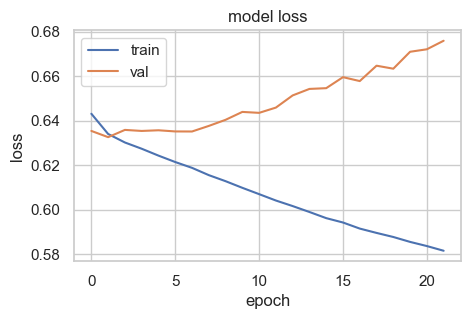

In [66]:
model_evaluation(history_MLP)

In [67]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_val, y_val)

5262/5262 [==============================] - 13s 2ms/step - loss: 0.6759 - accuracy: 0.6253


In [68]:
# Print the evaluation results
print('Val Loss:', loss)
print('Val Accuracy:', accuracy)

Val Loss: 0.6758808493614197
Val Accuracy: 0.6252627968788147


In [69]:
y_train.shape

(341830, 1)

In [70]:
ks_scoring = make_scorer(ks_results, needs_proba=True)

In [71]:
# Em seguida, desenvolvemos um novo modelo MLP com a abordagem de variação/otimização paramétrica com o uso do Optuna

In [72]:
def objective(trial):
    n_units = trial.suggest_categorical('n_units', [128, 256, 512, 1024])
    dropout = trial.suggest_float('dropout', 0.0, 0.5, step=0.1, log=False)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid', 'tanh'])

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=LEARNING_RATE)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=LEARNING_RATE)
    else:
        optimizer = RMSprop(learning_rate=LEARNING_RATE)    

    model = Sequential()
    model.add(Dense(n_units, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n_units, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation=activation))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    print(f'Training model...{model.summary()}')

    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[EarlyStopping('val_loss', patience=20, restore_best_weights=True)])

    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

    print('Val_loss: %.3f, Val_acc: %.3f' % (val_loss, val_acc))

    y_pred_mlp = model.predict(X_val)
    y_pred_mlp = np.where(y_pred_mlp > 0.5, 1, 0)    

    if((not np.any(y_pred_mlp)) or np.all(y_pred_mlp)):
        ks = 0
    else:
        ks = ks_results(reshape_plot(y_pred_mlp, y_val)[0], reshape_plot(y_pred_mlp, y_val)[1])
        
    trial.set_user_attr('roc_auc', roc_auc_score(y_val, y_pred_mlp))
    trial.set_user_attr('ks', ks)

    trial.report(ks, step=1)
    ###
    trial.set_user_attr('accuracy', accuracy_score(y_val, y_pred_mlp))
    trial.set_user_attr('precision', precision_score(y_val, y_pred_mlp))
    trial.set_user_attr('recall', recall_score(y_val, y_pred_mlp))
    trial.set_user_attr('f1', f1_score(y_val, y_pred_mlp))

    trial.report(ks, step=1)
    trial.report(roc_auc_score(y_val, y_pred_mlp), step=2)
    trial.report(accuracy_score(y_val, y_pred_mlp), step=3)
    trial.report(precision_score(y_val, y_pred_mlp), step=4)
    trial.report(recall_score(y_val, y_pred_mlp), step=5)
    trial.report(f1_score(y_val, y_pred_mlp), step=6)
    ###
    return ks

In [73]:
# Estabelecemos uma quantidade de 5 trials no optuna para a seleção dos melhores parâmetros

In [74]:
study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=8)

[I 2023-05-08 01:30:23,368] A new study created in memory with name: no-name-7a914f0f-af8a-4aab-86be-71adbf579937


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               124928    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 388,097
Trainable params: 388,097
Non-trainable params: 0
_________________________________________________________________
Training model...None
Epoch 1/10000
10683/10683 

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
[I 2023-05-08 02:04:00,501] Trial 0 finished with value: 0.2552549248090147 and parameters: {'n_units': 512, 'dropout': 0.5, 'optimizer': 'rmsprop', 'batch_size': 32, 'activation': 'tanh'}. Best is trial 0 with value: 0.2552549248090147.


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               124928    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 388,097
Trainable params: 388,097
Non-trainable params: 0
_________________________________________________________________
Training model...None
Epoch 1/10000
2671/2671 [=

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
[I 2023-05-08 02:12:06,205] Trial 1 finished with value: 0.28324399062855393 and parameters: {'n_units': 512, 'dropout': 0.4, 'optimizer': 'rmsprop', 'batch_size': 128, 'activation': 'tanh'}. Best is trial 1 with value: 0.28324399062855393.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               62464     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                                 
Total params: 128,513
Trainable params: 128,513
Non-trainable params: 0
_________________________________________________________________
Training model...None
Epoch 1/10000
2671/2671 [=

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
[I 2023-05-08 02:20:04,281] Trial 2 finished with value: 0.2787914119830504 and parameters: {'n_units': 256, 'dropout': 0.2, 'optimizer': 'adam', 'batch_size': 128, 'activation': 'tanh'}. Best is trial 1 with value: 0.28324399062855393.


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 256)               62464     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 256)               65792     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 128,513
Trainable params: 128,513
Non-trainable params: 0
_________________________________________________________________
Training model...None
Epoch 1/10000
2671/2671 [=

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
[I 2023-05-08 02:28:29,883] Trial 3 finished with value: 0.28553165026241795 and parameters: {'n_units': 256, 'dropout': 0.4, 'optimizer': 'rmsprop', 'batch_size': 128, 'activation': 'sigmoid'}. Best is trial 3 with value: 0.28553165026241795.


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 1024)              249856    
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 dense_16 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 1,300,481
Trainable params: 1,300,481
Non-trainable params: 0
_________________________________________________________________
Training model...None
Epoch 1/10000
10683/10

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
[I 2023-05-08 02:50:56,453] Trial 4 finished with value: 0.0 and parameters: {'n_units': 1024, 'dropout': 0.2, 'optimizer': 'adam', 'batch_size': 32, 'activation': 'relu'}. Best is trial 3 with value: 0.28553165026241795.


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 128)               31232     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               16512     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 47,873
Trainable params: 47,873
Non-trainable params: 0
_________________________________________________________________
Training model...None
Epoch 1/10000
2671/2671 [===

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
[I 2023-05-08 02:59:33,554] Trial 5 finished with value: 0.2884888060186696 and parameters: {'n_units': 128, 'dropout': 0.4, 'optimizer': 'adam', 'batch_size': 128, 'activation': 'sigmoid'}. Best is trial 5 with value: 0.2884888060186696.


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               31232     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 1)                 129       
                                                                 
Total params: 47,873
Trainable params: 47,873
Non-trainable params: 0
_________________________________________________________________
Training model...None
Epoch 1/10000
10683/10683 [=

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
[I 2023-05-08 04:38:38,876] Trial 6 finished with value: 0.2735715422913462 and parameters: {'n_units': 128, 'dropout': 0.4, 'optimizer': 'sgd', 'batch_size': 32, 'activation': 'relu'}. Best is trial 5 with value: 0.2884888060186696.


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 1024)              249856    
                                                                 
 dropout_14 (Dropout)        (None, 1024)              0         
                                                                 
 dense_24 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                                 
 dense_25 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 1,300,481
Trainable params: 1,300,481
Non-trainable params: 0
_________________________________________________________________
Training model...None
Epoch 1/10000
10683/10

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-05-08 05:00:49,867] Trial 7 finished with value: 0.0 and parameters: {'n_units': 1024, 'dropout': 0.30000000000000004, 'optimizer': 'sgd', 'bat

In [75]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 8
Best trial: {'n_units': 128, 'dropout': 0.4, 'optimizer': 'adam', 'batch_size': 128, 'activation': 'sigmoid'}


In [76]:
best_mlp = study.best_trial.params
best_mlp

{'n_units': 128,
 'dropout': 0.4,
 'optimizer': 'adam',
 'batch_size': 128,
 'activation': 'sigmoid'}

In [77]:
study.trials

ks = [trial.user_attrs['ks'] for trial in study.trials]
roc_auc = [trial.user_attrs['roc_auc'] for trial in study.trials]
accuracy = [trial.user_attrs['accuracy'] for trial in study.trials]
precision = [trial.user_attrs['precision'] for trial in study.trials]
recall = [trial.user_attrs['recall'] for trial in study.trials]
f1 = [trial.user_attrs['f1'] for trial in study.trials]


#results_opt = pd.DataFrame({'model': 'MLP Optuna','ks': ks, 'roc_auc': roc_auc, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}, index=[0])
results_opt = pd.DataFrame({'model': 'MLP Optuna','ks': ks, 'roc_auc': roc_auc, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

results_opt

,model,ks,roc_auc,accuracy,precision,recall,f1
0,MLP Optuna,0.255255,0.626676,0.626676,0.638645,0.583514,0.609836
1,MLP Optuna,0.283244,0.638336,0.638336,0.620048,0.714503,0.663933
2,MLP Optuna,0.278791,0.638318,0.638318,0.627137,0.682287,0.653551
3,MLP Optuna,0.285532,0.642630,0.642630,0.638358,0.658066,0.648062
4,MLP Optuna,0.000000,0.500000,0.500000,0.500000,1.000000,0.666667
5,MLP Optuna,0.288489,0.643818,0.643818,0.636398,0.671014,0.653248
6,MLP Optuna,0.273572,0.636292,0.636292,0.628570,0.666322,0.646896
7,MLP Optuna,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000


In [78]:
# Quando o modelo apresenta uma acurácia de 50%, o ks_score não pode ser matematicamente calculado. Tendo isso em vista, setamos os valores de ks para 0

In [79]:
mlp_opt = Sequential()
mlp_opt.add(Dense(units=best_mlp['n_units'], input_dim=X_train.shape[1], activation=best_mlp['activation']))
mlp_opt.add(Dropout(best_mlp['dropout']))
mlp_opt.add(Dense(units=best_mlp['n_units'], activation=best_mlp['activation']))
mlp_opt.add(Dropout(best_mlp['dropout']))
mlp_opt.add(Dense(1, activation=best_mlp['activation']))

mlp_opt.compile(loss='binary_crossentropy', optimizer=best_mlp['optimizer'], metrics=['accuracy'])

history_mlp_opt = mlp_opt.fit(X_train, y_train, epochs=EPOCHS, batch_size=best_mlp['batch_size'], validation_data=(X_val, y_val), callbacks=[EarlyStopping('val_loss', patience=20, restore_best_weights=True)])

Epoch 1/10000
2671/2671 [==============================] - 15s 6ms/step - loss: 0.6604 - accuracy: 0.6053 - val_loss: 0.6440 - val_accuracy: 0.6274
Epoch 2/10000
2671/2671 [==============================] - 15s 5ms/step - loss: 0.6460 - accuracy: 0.6260 - val_loss: 0.6394 - val_accuracy: 0.6338
Epoch 3/10000
2671/2671 [==============================] - 15s 6ms/step - loss: 0.6421 - accuracy: 0.6307 - val_loss: 0.6367 - val_accuracy: 0.6349
Epoch 4/10000
2671/2671 [==============================] - 15s 6ms/step - loss: 0.6389 - accuracy: 0.6335 - val_loss: 0.6355 - val_accuracy: 0.6365
Epoch 5/10000
2671/2671 [==============================] - 15s 6ms/step - loss: 0.6368 - accuracy: 0.6358 - val_loss: 0.6331 - val_accuracy: 0.6397
Epoch 6/10000
2671/2671 [==============================] - 15s 6ms/step - loss: 0.6351 - accuracy: 0.6382 - val_loss: 0.6314 - val_accuracy: 0.6406
Epoch 7/10000
2671/2671 [==============================] - 15s 6ms/step - loss: 0.6340 - accuracy: 0.6388 - val_

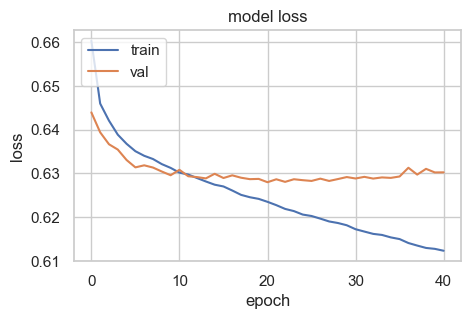

In [80]:
model_evaluation(history_mlp_opt)

In [81]:
loss, accuracy = mlp_opt.evaluate(X_val, y_val)

print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

5262/5262 [==============================] - 13s 2ms/step - loss: 0.6280 - accuracy: 0.6450
Test Loss: 0.6280047297477722
Test Accuracy: 0.645047128200531


In [82]:
y_pred = mlp_opt.predict(X_val)

5262/5262 [==============================] - 7s 1ms/step


In [83]:
y_pred.round()

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [84]:
np.unique(y_pred)

array([0.0264114 , 0.03021671, 0.0317041 , ..., 0.900385  , 0.90650797,
       0.9104189 ], dtype=float32)

In [85]:
y_pred.shape

(168366, 1)

In [86]:
y_val.shape

(168366, 1)

In [87]:
ks = ks_2samp(y_pred[y_val == 1], y_pred[y_val != 1]) 
ks

KstestResult(statistic=0.2926125227183635, pvalue=0.0)

Gerando análises para o modelo <keras.engine.sequential.Sequential object at 0x000001F32D0421D0>
5262/5262 [==============================] - 7s 1ms/step
[[0.143978  ]
 [0.4498106 ]
 [0.6637683 ]
 ...
 [0.66831   ]
 [0.6104322 ]
 [0.74857414]]


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


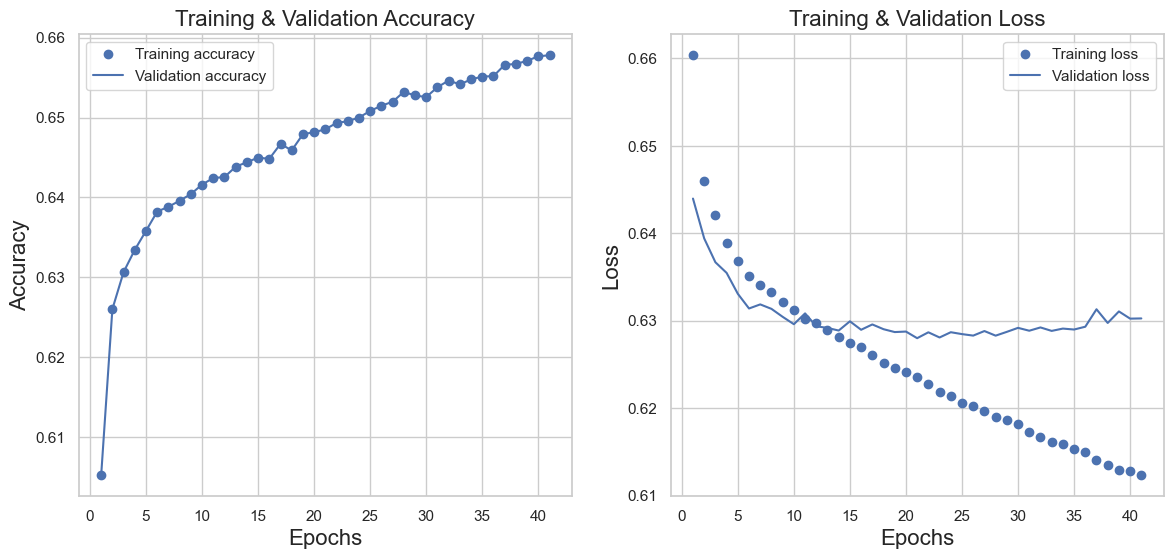

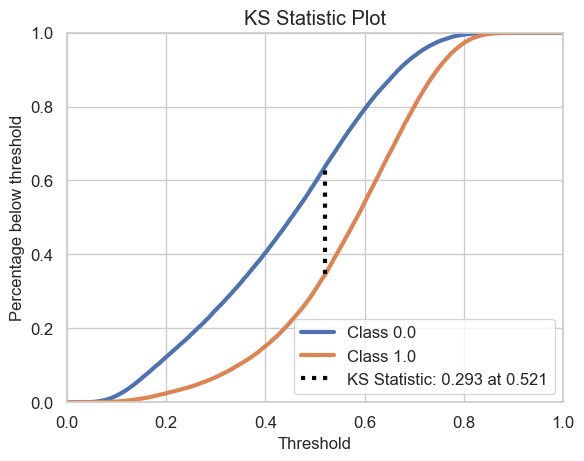

type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


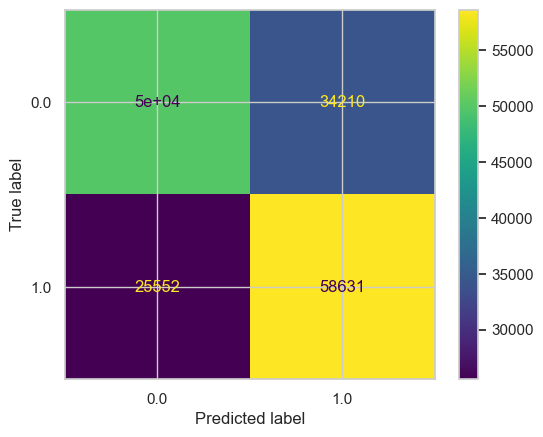


5262/5262 [==============================] - 13s 2ms/step - loss: 0.6280 - accuracy: 0.6450
Score:            [0.6280047297477722, 0.645047128200531]
Accuracy:         0.6450
Recall:           0.6965
Precision:        0.6315
F1:               0.6624
AUROC:            0.7009
KS:               0.2932


In [88]:
historyPlot(mlp_opt, history_mlp_opt.history, X_val, y_val, True)

<AxesSubplot: >

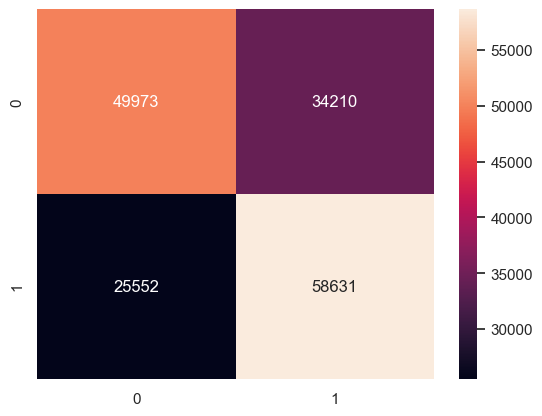

In [89]:
sns.heatmap(confusion_matrix(y_val, y_pred.round()), annot=True, fmt='g')

## Definindo Random Forest básico

In [90]:
# Fazemos uma análise para um modelo Random Forest com parâmetros arbitrários

In [91]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

for _ in tqdm(range(1)):
    rf.fit(X_train, y_train.ravel())

y_pred_rf = rf.predict(X_val)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:04<00:00, 64.83s/it]


In [92]:
def sns_heatmap(y_train, y_pred):
    sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='g')

In [93]:
def sk_model_evaluation(model_name=rf, y_val=y_val, y_pred=y_pred):
    print('The model used is {}'.format(model_name))
    print('Accuracy Score:', accuracy_score(y_val, y_pred))
    print('Precision Score:', precision_score(y_val, y_pred))
    print('Recall Score:', recall_score(y_val, y_pred))
    print('F1 Score:', f1_score(y_val, y_pred))
    print('ROC AUC Score:', roc_auc_score(y_val, y_pred))
    print('SK score:', ks_results(reshape_plot(y_val, y_pred)[0], reshape_plot(y_val, y_pred)[1]))
    print('Classification Report:\n', classification_report(y_val, y_pred))
    print('Confusion Matrix:\n', sns_heatmap(y_val, y_pred))
    plt.show()

The model used is RandomForestClassifier(n_jobs=-1, random_state=42)
Accuracy Score: 0.6067317629450126
Precision Score: 0.663286446407153
Recall Score: 0.43355546844374754
F1 Score: 0.5243626489666616
ROC AUC Score: 0.6067317629450126
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
SK score: 0.21346352589002537
Classification Report:
               precision    recall  f1-score   support

         0.0       0.58      0.78      0.66     84183
         1.0       0.66      0.43      0.52     84183

    accuracy                           0.61    168366
   macro avg       0.62      0.61      0.59    168366
weighted avg       0.62      0.61      0.59    168366

Confusion Matrix:
 None


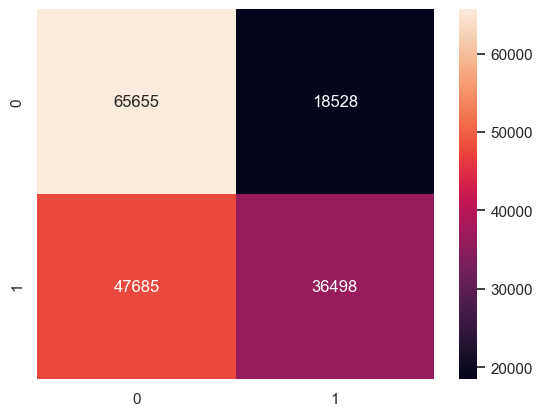

In [94]:
sk_model_evaluation(rf, y_val, y_pred_rf)


In [95]:
ks = ks_results(reshape_plot(y_val, y_pred_rf)[0], reshape_plot(y_val, y_pred_rf)[1])
roc = roc_auc_score(y_val, y_pred_rf)
accuracy = accuracy_score(y_val, y_pred_rf)
precision = precision_score(y_val, y_pred_rf)
recall = recall_score(y_val, y_pred_rf)
f1 = f1_score(y_val, y_pred_rf)

type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


In [96]:
results_basic_rf = pd.DataFrame({'model': 'Random Forest Básico', 'ks': ks, 'roc': roc, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}, index=[0])
results_basic = pd.concat([results_basic, results_basic_rf])
results_basic

,model,ks,roc,accuracy,precision,recall,f1
0,MLP Básico,0.016749,0.493003,0.493003,0.495022,0.695817,0.578491
0,Random Forest Básico,0.213464,0.606732,0.606732,0.663286,0.433555,0.524363


In [97]:
# Vemos acima que o modelo Random Forest Básico supera o modelo MLP Básico para os nosso parâmetros arbitrários

In [98]:
# Agora, fazemos o mesmo estudo. Contudo, utilizamos o optuna para otimizar os parâmetros da Random Forest

In [99]:
rf_params = {
    'n_estimators': [100, 300, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 10],
    'min_samples_split': [2, 8, 10],
    'min_samples_leaf': [4, 6, 10],
    'max_features': ['sqrt', 'log2', None],
}

In [100]:
# use optuna to find the best parameters described above using roc_auc and ks as metrics

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500, step=100)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 2, 10, step=2)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10, step=2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 4, 10, step=2)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=42, n_jobs=-1, verbose=3)

    model.fit(X_train, y_train.ravel())

    y_pred = model.predict(X_val)

    if((not np.any(y_pred)) or np.all(y_pred)):
        ks = 0
    else:
        ks = ks_results(reshape_plot(y_pred, y_val)[0], reshape_plot(y_pred, y_val)[1])

    trial.set_user_attr('roc_auc', roc_auc_score(y_val, y_pred))
    trial.set_user_attr('ks', ks)
    trial.set_user_attr('accuracy', accuracy_score(y_val, y_pred))
    trial.set_user_attr('precision', precision_score(y_val, y_pred))
    trial.set_user_attr('recall', recall_score(y_val, y_pred))
    trial.set_user_attr('f1', f1_score(y_val, y_pred))

    trial.report(ks, step=1)
    trial.report(roc_auc_score(y_val, y_pred), step=2)
    trial.report(accuracy_score(y_val, y_pred), step=3)
    trial.report(precision_score(y_val, y_pred), step=4)
    trial.report(recall_score(y_val, y_pred), step=5)
    trial.report(f1_score(y_val, y_pred), step=6)

    return ks

In [101]:
study = optuna.create_study(direction='maximize')

study.optimize(objective_rf, n_trials=8)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-05-08 05:12:58,741] A new study created in memory with name: no-name-1d726cdf-792c-4ad2-8cc8-e63cad9e797e
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200building tree 17 of 200

building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.5s


building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   32.3s


building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   59.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.7s finished


type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


[I 2023-05-08 05:14:00,385] Trial 0 finished with value: 0.27264451618884433 and parameters: {'n_estimators': 200, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.27264451618884433.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   13.3s


building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


[I 2023-05-08 05:15:51,344] Trial 1 finished with value: 0.20601271147250766 and parameters: {'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 0 with value: 0.27264451618884433.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.1s


building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   28.7s


building tree 119 of 300
building tree 120 of 300
building tree 121 of 300
building tree 122 of 300
building tree 123 of 300
building tree 124 of 300
building tree 125 of 300
building tree 126 of 300
building tree 127 of 300
building tree 128 of 300
building tree 129 of 300
building tree 130 of 300
building tree 131 of 300
building tree 132 of 300
building tree 133 of 300
building tree 134 of 300
building tree 135 of 300
building tree 136 of 300
building tree 137 of 300
building tree 138 of 300
building tree 139 of 300
building tree 140 of 300
building tree 141 of 300
building tree 142 of 300
building tree 143 of 300
building tree 144 of 300
building tree 145 of 300
building tree 146 of 300
building tree 147 of 300
building tree 148 of 300
building tree 149 of 300
building tree 150 of 300
building tree 151 of 300
building tree 152 of 300
building tree 153 of 300
building tree 154 of 300
building tree 155 of 300
building tree 156 of 300
building tree 157 of 300
building tree 158 of 300


[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.2min


building tree 279 of 300
building tree 280 of 300
building tree 281 of 300
building tree 282 of 300
building tree 283 of 300
building tree 284 of 300
building tree 285 of 300
building tree 286 of 300
building tree 287 of 300
building tree 288 of 300
building tree 289 of 300
building tree 290 of 300
building tree 291 of 300
building tree 292 of 300
building tree 293 of 300
building tree 294 of 300
building tree 295 of 300
building tree 296 of 300
building tree 297 of 300
building tree 298 of 300
building tree 299 of 300
building tree 300 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    1.0s finished


type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


[I 2023-05-08 05:17:13,298] Trial 2 finished with value: 0.272611191592674 and parameters: {'n_estimators': 300, 'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.27264451618884433.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.3s


building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.3s finished


type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


[I 2023-05-08 05:17:41,656] Trial 3 finished with value: 0.2710033892338856 and parameters: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.27264451618884433.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   27.1s


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


[I 2023-05-08 05:21:28,829] Trial 4 finished with value: 0.238012387979111 and parameters: {'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 0 with value: 0.27264451618884433.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.6s


building tree 22 of 200building tree 23 of 200

building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200building tree 41 of 200

building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200building tree 56 of 200

building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   15.3s


building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   28.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.3s finished


type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


[I 2023-05-08 05:21:58,382] Trial 5 finished with value: 0.23388874064956167 and parameters: {'n_estimators': 200, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.27264451618884433.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   24.8s


building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500building tree 127 of 500

building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500


[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.0min


building tree 278 of 500
building tree 279 of 500
building tree 280 of 500
building tree 281 of 500
building tree 282 of 500
building tree 283 of 500
building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    1.6s finished


type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


[I 2023-05-08 05:23:53,215] Trial 6 finished with value: 0.2584140450788643 and parameters: {'n_estimators': 500, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.27264451618884433.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   26.9s


building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  4.0min


building tree 117 of 300
building tree 118 of 300
building tree 119 of 300
building tree 120 of 300
building tree 121 of 300
building tree 122 of 300
building tree 123 of 300
building tree 124 of 300
building tree 125 of 300
building tree 126 of 300
building tree 127 of 300
building tree 128 of 300
building tree 129 of 300
building tree 130 of 300
building tree 131 of 300
building tree 132 of 300
building tree 133 of 300
building tree 134 of 300
building tree 135 of 300
building tree 136 of 300
building tree 137 of 300
building tree 138 of 300
building tree 139 of 300
building tree 140 of 300
building tree 141 of 300
building tree 142 of 300
building tree 143 of 300
building tree 144 of 300
building tree 145 of 300
building tree 146 of 300
building tree 147 of 300
building tree 148 of 300
building tree 149 of 300
building tree 150 of 300
building tree 151 of 300
building tree 152 of 300
building tree 153 of 300
building tree 154 of 300
building tree 155 of 300
building tree 156 of 300


[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  9.9min


building tree 277 of 300
building tree 278 of 300
building tree 279 of 300
building tree 280 of 300
building tree 281 of 300
building tree 282 of 300
building tree 283 of 300
building tree 284 of 300
building tree 285 of 300
building tree 286 of 300
building tree 287 of 300
building tree 288 of 300
building tree 289 of 300
building tree 290 of 300
building tree 291 of 300
building tree 292 of 300
building tree 293 of 300
building tree 294 of 300
building tree 295 of 300
building tree 296 of 300
building tree 297 of 300
building tree 298 of 300
building tree 299 of 300
building tree 300 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 11.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    0.5s finished


type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


[I 2023-05-08 05:35:02,289] Trial 7 finished with value: 0.23895591650505882 and parameters: {'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 0 with value: 0.27264451618884433.


Number of finished trials: 8
Best trial: {'n_estimators': 200, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt'}


In [102]:
study.trials[0].params

{'n_estimators': 200,
 'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_split': 2,
 'min_samples_leaf': 10,
 'max_features': 'sqrt'}

In [103]:
study.trials

ks = [trial.user_attrs['ks'] for trial in study.trials]
roc_auc = [trial.user_attrs['roc_auc'] for trial in study.trials]
accuracy = [trial.user_attrs['accuracy'] for trial in study.trials]
precision = [trial.user_attrs['precision'] for trial in study.trials]
recall = [trial.user_attrs['recall'] for trial in study.trials]
f1 = [trial.user_attrs['f1'] for trial in study.trials]

results_opt_rfo = pd.DataFrame({'model': 'Random Forest Optuna','ks': ks, 'roc_auc': roc_auc, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})
results_opt = pd.concat([results_opt, results_opt_rfo])
results_opt

,model,ks,roc_auc,accuracy,precision,recall,f1
0,MLP Optuna,0.255255,0.626676,0.626676,0.638645,0.583514,0.609836
1,MLP Optuna,0.283244,0.638336,0.638336,0.620048,0.714503,0.663933
2,MLP Optuna,0.278791,0.638318,0.638318,0.627137,0.682287,0.653551
3,MLP Optuna,0.285532,0.642630,0.642630,0.638358,0.658066,0.648062
4,MLP Optuna,0.000000,0.500000,0.500000,0.500000,1.000000,0.666667
5,MLP Optuna,0.288489,0.643818,0.643818,0.636398,0.671014,0.653248
6,MLP Optuna,0.273572,0.636292,0.636292,0.628570,0.666322,0.646896
7,MLP Optuna,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000
0,Random Forest Optuna,0.272645,0.634148,0.634148,0.619107,0.697290,0.655877
1,Random Forest Optuna,0.206013,0.594182,0.594182,0.572857,0.740530,0.645990


In [104]:
# Vemos a cima os trials do modelo Random Forest otimizado pelo Optuna  

In [105]:
best_rf = study.best_trial.params
best_rf

{'n_estimators': 200,
 'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_split': 2,
 'min_samples_leaf': 10,
 'max_features': 'sqrt'}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 200building tree 2 of 200

building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.6s


building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   32.2s


building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200building tree 134 of 200

building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   59.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s


Gerando análises para o modelo RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_leaf=10,
                       n_estimators=200, n_jobs=-1, random_state=42, verbose=3)


[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.7s finished
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


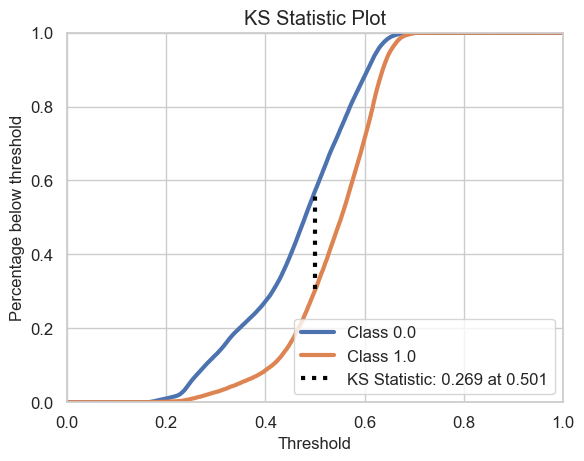

type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


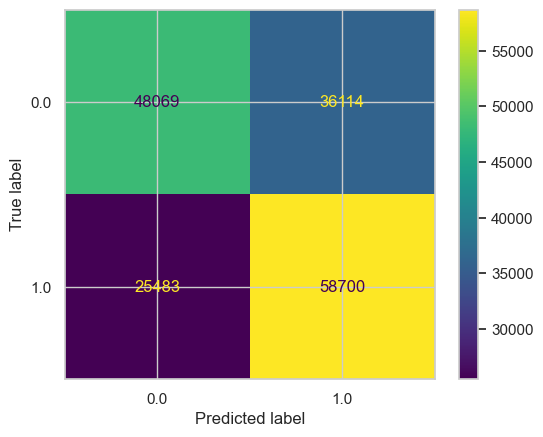


Accuracy:         0.6341
Recall:           0.6973
Precision:        0.6191
F1:               0.6559
AUROC:            0.6863
KS:               0.2726


In [106]:
rf_opt = RandomForestClassifier(**best_rf, random_state=42, n_jobs=-1, verbose=3)

rf_opt.fit(X_train, y_train.ravel())

testePlot(rf_opt, X_val, y_val)

In [107]:
# Fazemos a análise com um modelo de Gradient Boosting Classifier com parâmetros arbitrários

In [108]:
gb = GradientBoostingClassifier(random_state=42, verbose=4)

gb.fit(X_train, y_train.ravel())

y_pred_gb = gb.predict(X_val)

      Iter       Train Loss   Remaining Time 
         1           1.3742           14.60m
         2           1.3643           14.33m
         3           1.3558           14.33m
         4           1.3488           14.18m
         5           1.3421           13.97m
         6           1.3367           13.78m
         7           1.3316           13.62m
         8           1.3267           13.50m
         9           1.3224           13.37m
        10           1.3190           13.21m
        11           1.3158           13.08m
        12           1.3129           12.94m
        13           1.3093           12.78m
        14           1.3069           12.61m
        15           1.3047           12.45m
        16           1.3027           12.31m
        17           1.2994           12.16m
        18           1.2967           12.01m
        19           1.2943           11.88m
        20           1.2928           11.72m
        21           1.2914           11.54m
        2

The model used is GradientBoostingClassifier(random_state=42, verbose=4)
Accuracy Score: 0.6513013316227741
Precision Score: 0.6387412313188968
Recall Score: 0.6965658149507621
F1 Score: 0.6664014955650134
ROC AUC Score: 0.6513013316227743
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
SK score: 0.30260266324554835
Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.61      0.63     84183
         1.0       0.64      0.70      0.67     84183

    accuracy                           0.65    168366
   macro avg       0.65      0.65      0.65    168366
weighted avg       0.65      0.65      0.65    168366

Confusion Matrix:
 None


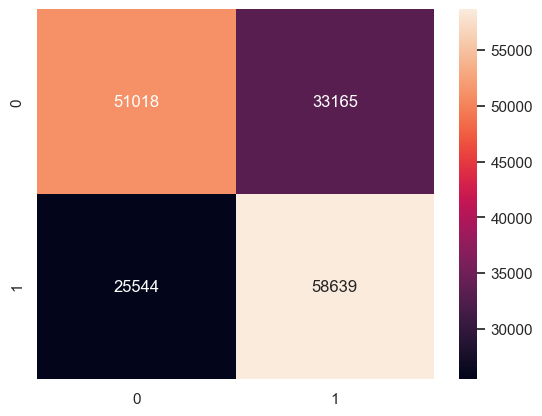

In [109]:
sk_model_evaluation(gb, y_val, y_pred_gb)

In [110]:
ks = ks_results(reshape_plot(y_val, y_pred_gb)[0], reshape_plot(y_val, y_pred_gb)[1])
roc = roc_auc_score(y_val, y_pred_gb)
accuracy = accuracy_score(y_val, y_pred_gb)
precision = precision_score(y_val, y_pred_gb)
recall = recall_score(y_val, y_pred_gb)
f1 = f1_score(y_val, y_pred_gb)

results_basic_gb = pd.DataFrame({'model': 'Gradient Boosting Básico', 'ks': ks, 'roc': roc, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}, index=[0])
results_basic = pd.concat([results_basic, results_basic_gb])
results_basic

type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


,model,ks,roc,accuracy,precision,recall,f1
0,MLP Básico,0.016749,0.493003,0.493003,0.495022,0.695817,0.578491
0,Random Forest Básico,0.213464,0.606732,0.606732,0.663286,0.433555,0.524363
0,Gradient Boosting Básico,0.302603,0.651301,0.651301,0.638741,0.696566,0.666401


In [111]:
# Realizamos uma variação paramétrica no modelo Gradient Boosting Classifier com o uso de optuna

In [112]:
def objective_gb(trial):
    loss = trial.suggest_categorical('loss', ['log_loss', 'deviance', 'exponential'])
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
    n_estimators = trial.suggest_int('n_estimators', 100, 500, step=100)

    model = GradientBoostingClassifier(loss=loss, learning_rate=learning_rate, n_estimators=n_estimators, random_state=42, verbose=3)

    model.fit(X_train, y_train.ravel())

    y_pred = model.predict(X_val)

    if((not np.any(y_pred)) or np.all(y_pred)):
        ks = 0
    else:
        ks = ks_results(reshape_plot(y_pred, y_val)[0], reshape_plot(y_pred, y_val)[1])

    trial.set_user_attr('roc_auc', roc_auc_score(y_val, y_pred))
    trial.set_user_attr('ks', ks)
    trial.set_user_attr('accuracy', accuracy_score(y_val, y_pred))
    trial.set_user_attr('precision', precision_score(y_val, y_pred))
    trial.set_user_attr('recall', recall_score(y_val, y_pred))
    trial.set_user_attr('f1', f1_score(y_val, y_pred))

    trial.report(ks, step=1)
    trial.report(roc_auc_score(y_val, y_pred), step=2)
    trial.report(accuracy_score(y_val, y_pred), step=3)
    trial.report(precision_score(y_val, y_pred), step=4)
    trial.report(recall_score(y_val, y_pred), step=5)
    trial.report(f1_score(y_val, y_pred), step=6)

    return ks

In [113]:
study_gb = optuna.create_study(direction='maximize')
#study_gb.optimize(objective_gb, n_trials=4)
study_gb.optimize(objective_gb, n_trials=8)

[I 2023-05-08 05:50:26,025] A new study created in memory with name: no-name-56b6d00e-2cf6-4f38-a679-f3a69ba75126
C:\Users\User\AppData\Local\Temp\ipykernel_8820\744561768.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)


      Iter       Train Loss   Remaining Time 
         1           1.3829           71.75m
         2           1.3798           71.93m
         3           1.3767           71.76m
         4           1.3739           71.72m
         5           1.3711           71.52m
         6           1.3685           71.39m
         7           1.3660           71.29m
         8           1.3637           71.15m
         9           1.3614           71.07m
        10           1.3591           70.93m
        11           1.3571           70.76m
        12           1.3550           70.68m
        13           1.3531           70.59m
        14           1.3511           70.27m
        15           1.3493           70.13m
        16           1.3476           69.93m
        17           1.3459           69.78m
        18           1.3443           69.61m
        19           1.3428           69.42m
        20           1.3413           69.21m
        21           1.3398           69.04m
        2

[I 2023-05-08 07:01:28,459] Trial 0 finished with value: 0.30745626807263543 and parameters: {'loss': 'log_loss', 'learning_rate': 0.026750825344070427, 'n_estimators': 500}. Best is trial 0 with value: 0.30745626807263543.
C:\Users\User\AppData\Local\Temp\ipykernel_8820\744561768.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           1.3858           14.35m
         2           1.3853           14.18m
         3           1.3848           14.07m
         4           1.3843           13.93m
         5           1.3838           13.79m
         6           1.3833           13.67m
         7           1.3828           13.51m
         8           1.3823           13.38m
         9           1.3818           13.24m
        10           1.3813           13.09m
        11           1.3808           12.95m
        12           1.3804           12.81m
        13           1.3799           12.65m
        14           1.3794           12.49m
        15           1.3790           12.35m
        16           1.3785           12.20m
        17           1.3781           12.05m
        18           1.3776           11.90m
        19           1.3772           11.76m
        20           1.3767           11.61m
        21           1.3763           11.47m
        2

[I 2023-05-08 07:16:02,789] Trial 1 finished with value: 0.23996146933070173 and parameters: {'loss': 'deviance', 'learning_rate': 0.00405864612769025, 'n_estimators': 100}. Best is trial 0 with value: 0.30745626807263543.
C:\Users\User\AppData\Local\Temp\ipykernel_8820\744561768.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           1.3803           58.10m
         2           1.3748           58.24m
         3           1.3698           57.95m
         4           1.3653           57.74m
         5           1.3610           57.50m
         6           1.3572           57.24m
         7           1.3533           57.06m
         8           1.3501           56.98m
         9           1.3468           56.89m
        10           1.3440           56.73m
        11           1.3411           56.49m
        12           1.3383           56.37m
        13           1.3359           56.16m
        14           1.3335           56.06m
        15           1.3313           55.93m
        16           1.3289           55.76m
        17           1.3270           55.59m
        18           1.3251           55.41m
        19           1.3231           55.35m
        20           1.3213           55.22m
        21           1.3194           55.07m
        2

[I 2023-05-08 08:12:55,966] Trial 2 finished with value: 0.31271208752783136 and parameters: {'loss': 'deviance', 'learning_rate': 0.04841394120518027, 'n_estimators': 400}. Best is trial 2 with value: 0.31271208752783136.
C:\Users\User\AppData\Local\Temp\ipykernel_8820\744561768.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           1.3859           57.77m
         2           1.3855           57.81m
         3           1.3851           57.75m
         4           1.3847           57.60m
         5           1.3843           57.42m
         6           1.3839           57.18m
         7           1.3835           56.97m
         8           1.3831           56.90m
         9           1.3827           56.77m
        10           1.3823           56.61m
        11           1.3819           56.39m
        12           1.3816           56.24m
        13           1.3812           56.16m
        14           1.3808           56.04m
        15           1.3804           55.93m
        16           1.3801           55.80m
        17           1.3797           55.64m
        18           1.3793           55.51m
        19           1.3790           55.37m
        20           1.3786           55.22m
        21           1.3782           55.08m
        2

[I 2023-05-08 09:11:22,898] Trial 3 finished with value: 0.26369609864435634 and parameters: {'loss': 'deviance', 'learning_rate': 0.0032092815842897117, 'n_estimators': 400}. Best is trial 2 with value: 0.31271208752783136.
C:\Users\User\AppData\Local\Temp\ipykernel_8820\744561768.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)


      Iter       Train Loss   Remaining Time 
         1           1.3821           57.79m
         2           1.3782           57.61m
         3           1.3746           57.88m
         4           1.3712           57.57m
         5           1.3679           57.26m
         6           1.3649           57.00m
         7           1.3620           56.88m
         8           1.3593           56.80m
         9           1.3566           56.70m
        10           1.3542           56.62m
        11           1.3518           56.45m
        12           1.3494           56.22m
        13           1.3473           56.06m
        14           1.3453           55.93m
        15           1.3432           55.76m
        16           1.3414           55.65m
        17           1.3397           55.54m
        18           1.3378           55.42m
        19           1.3361           55.29m
        20           1.3345           55.19m
        21           1.3329           55.06m
        2

[I 2023-05-08 10:08:16,469] Trial 4 finished with value: 0.30731462332525283 and parameters: {'loss': 'log_loss', 'learning_rate': 0.03323001202960774, 'n_estimators': 400}. Best is trial 2 with value: 0.31271208752783136.
C:\Users\User\AppData\Local\Temp\ipykernel_8820\744561768.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           1.3859           58.01m
         2           1.3856           58.16m
         3           1.3852           57.81m
         4           1.3849           57.80m
         5           1.3845           57.69m
         6           1.3842           57.66m
         7           1.3839           57.48m
         8           1.3835           57.28m
         9           1.3832           57.07m
        10           1.3828           56.97m
        11           1.3825           56.80m
        12           1.3822           56.58m
        13           1.3818           56.35m
        14           1.3815           56.24m
        15           1.3812           56.14m
        16           1.3809           55.98m
        17           1.3805           55.77m
        18           1.3802           55.62m
        19           1.3799           55.46m
        20           1.3796           55.30m
        21           1.3792           55.15m
        2

[I 2023-05-08 11:06:46,474] Trial 5 finished with value: 0.2601712000670043 and parameters: {'loss': 'deviance', 'learning_rate': 0.002787249034465243, 'n_estimators': 400}. Best is trial 2 with value: 0.31271208752783136.
C:\Users\User\AppData\Local\Temp\ipykernel_8820\744561768.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           1.3751           58.19m
         2           1.3658           57.88m
         3           1.3577           57.71m
         4           1.3508           57.49m
         5           1.3450           57.31m
         6           1.3396           57.08m
         7           1.3346           56.91m
         8           1.3304           56.79m
         9           1.3261           56.60m
        10           1.3228           56.62m
        11           1.3194           56.63m
        12           1.3164           56.59m
        13           1.3120           56.42m
        14           1.3092           56.26m
        15           1.3069           56.10m
        16           1.3048           55.91m
        17           1.3018           55.77m
        18           1.2994           55.58m
        19           1.2978           55.43m
        20           1.2962           55.30m
        21           1.2929           55.27m
        2

[I 2023-05-08 12:03:20,730] Trial 6 finished with value: 0.31691897587568696 and parameters: {'loss': 'deviance', 'learning_rate': 0.09206820030188005, 'n_estimators': 400}. Best is trial 6 with value: 0.31691897587568696.
C:\Users\User\AppData\Local\Temp\ipykernel_8820\744561768.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)


      Iter       Train Loss   Remaining Time 
         1           1.3813           29.33m
         2           1.3766           29.24m
         3           1.3723           28.90m
         4           1.3683           28.69m
         5           1.3646           28.48m
         6           1.3611           28.30m
         7           1.3578           28.14m
         8           1.3547           27.99m
         9           1.3517           27.78m
        10           1.3490           27.64m
        11           1.3463           27.49m
        12           1.3438           27.28m
        13           1.3415           27.12m
        14           1.3393           26.97m
        15           1.3371           26.83m
        16           1.3350           26.71m
        17           1.3331           26.61m
        18           1.3312           26.47m
        19           1.3296           26.34m
        20           1.3276           26.23m
        21           1.3261           26.10m
        2

[I 2023-05-08 12:32:00,359] Trial 7 finished with value: 0.3003775240727424 and parameters: {'loss': 'log_loss', 'learning_rate': 0.04039130629714892, 'n_estimators': 200}. Best is trial 6 with value: 0.31691897587568696.


In [114]:
study_gb.trials

[FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.30745626807263543], datetime_start=datetime.datetime(2023, 5, 8, 5, 50, 26, 27082), datetime_complete=datetime.datetime(2023, 5, 8, 7, 1, 28, 459717), params={'loss': 'log_loss', 'learning_rate': 0.026750825344070427, 'n_estimators': 500}, user_attrs={'roc_auc': 0.6526377059501324, 'ks': 0.30745626807263543, 'accuracy': 0.6526377059501325, 'precision': 0.6407809538417714, 'recall': 0.6947483458655548, 'f1': 0.6666742659128213}, system_attrs={}, intermediate_values={1: 0.30745626807263543, 2: 0.6526377059501324, 3: 0.6526377059501325, 4: 0.6407809538417714, 5: 0.6947483458655548, 6: 0.6666742659128213}, distributions={'loss': CategoricalDistribution(choices=('log_loss', 'deviance', 'exponential')), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'n_estimators': IntDistribution(high=500, log=False, low=100, step=100)}, trial_id=0, value=None),
 FrozenTrial(number=1, state=TrialState.COMPLETE, values

In [116]:
study_gb.trials

ks = [trial.user_attrs['ks'] for trial in study_gb.trials]
roc_auc = [trial.user_attrs['roc_auc'] for trial in study_gb.trials]
accuracy = [trial.user_attrs['accuracy'] for trial in study_gb.trials]
precision = [trial.user_attrs['precision'] for trial in study_gb.trials]
recall = [trial.user_attrs['recall'] for trial in study_gb.trials]
f1 = [trial.user_attrs['f1'] for trial in study_gb.trials]

results_opt_gb = pd.DataFrame({'model': 'Gradient Boosting Optuna','ks': ks, 'roc_auc': roc_auc, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})
#results_opt_gb = pd.DataFrame({'model': 'Gradient Boosting Optuna','ks': ks, 'roc_auc': roc_auc, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}, index=[0])

results_opt = pd.concat([results_opt, results_opt_gb])
results_opt

,model,ks,roc_auc,accuracy,precision,recall,f1
0,MLP Optuna,0.255255,0.626676,0.626676,0.638645,0.583514,0.609836
1,MLP Optuna,0.283244,0.638336,0.638336,0.620048,0.714503,0.663933
2,MLP Optuna,0.278791,0.638318,0.638318,0.627137,0.682287,0.653551
3,MLP Optuna,0.285532,0.642630,0.642630,0.638358,0.658066,0.648062
4,MLP Optuna,0.000000,0.500000,0.500000,0.500000,1.000000,0.666667
5,MLP Optuna,0.288489,0.643818,0.643818,0.636398,0.671014,0.653248
6,MLP Optuna,0.273572,0.636292,0.636292,0.628570,0.666322,0.646896
7,MLP Optuna,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000
0,Random Forest Optuna,0.272645,0.634148,0.634148,0.619107,0.697290,0.655877
1,Random Forest Optuna,0.206013,0.594182,0.594182,0.572857,0.740530,0.645990


In [117]:
best_gb = study_gb.best_trial.params
best_gb

{'loss': 'deviance', 'learning_rate': 0.09206820030188005, 'n_estimators': 400}

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           1.3751           59.75m
         2           1.3658           59.98m
         3           1.3577           60.30m
         4           1.3508           60.34m
         5           1.3450           59.77m
         6           1.3396           59.34m
         7           1.3346           59.18m
         8           1.3304           59.01m
         9           1.3261           59.09m
        10           1.3228           58.99m
        11           1.3194           58.87m
        12           1.3164           58.99m
        13           1.3120           59.00m
        14           1.3092           58.73m
        15           1.3069           58.47m
        16           1.3048           58.45m
        17           1.3018           58.53m
        18           1.2994           58.49m
        19           1.2978           58.30m
        20           1.2962           58.12m
        21           1.2929           57.99m
        2

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


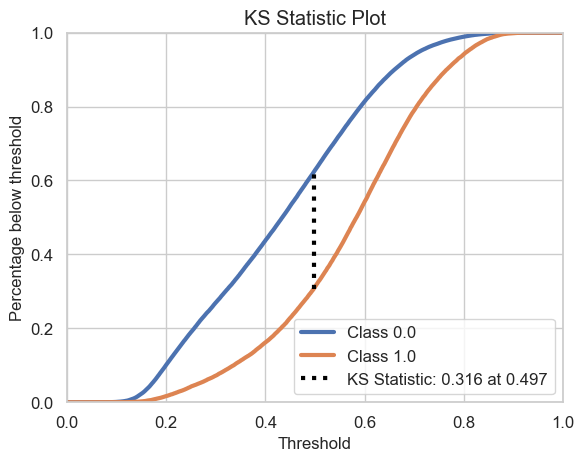

type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


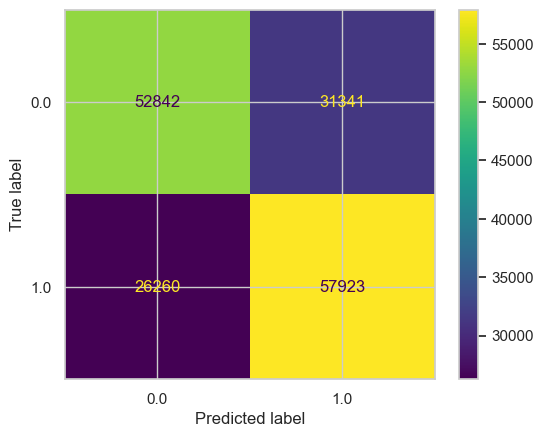


Accuracy:         0.6579
Recall:           0.6881
Precision:        0.6489
F1:               0.6679
AUROC:            0.7155
KS:               0.3169


In [119]:
gb_opt = GradientBoostingClassifier(loss=best_gb['loss'], learning_rate=best_gb['learning_rate'], n_estimators=best_gb['n_estimators'], random_state=42, verbose=3)

gb_opt.fit(X_train, y_train.ravel())

testePlot(gb_opt, X_val, y_val)

# Ensemble MLP

In [120]:
# Analisamos, agora, a abordagem de Ensemble de modelos MLP

In [121]:
from tensorflow.keras.optimizers import Adam, RMSprop

def createMLPModel(units, dropout, optimizer_name, activation, batch_size, callbacks, learning_rate=LEARNING_RATE,epochs=EPOCHS):
    optimizer_map = {
        'adam': Adam,
        'rmsprop': RMSprop,
    }
    optimizer_class = optimizer_map.get(optimizer_name)
    optimizer = optimizer_class(learning_rate=learning_rate)

    mlp = Sequential()
    mlp.add(Dense(units=units, activation=activation, input_shape=(X_train.shape[1],)))
    mlp.add(Dropout(dropout))
    mlp.add(Dense(units=units, activation=activation))
    mlp.add(Dropout(dropout))
    mlp.add(Dense(1, activation=activation))

    mlp.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['binary_accuracy'])

    return mlp

In [122]:
# Esses modelos foram selecionados com base em alguns dos melhores parâmetros gerados pelo optuna relativos a MLPs

In [123]:
n_models = 2

paramsListMlp = [
    {'units': 128, 'dropout': 0.0, 'optimizer_name': 'rmsprop', 'learning_rate': 0.0205, 'batch_size': 128, 'activation': 'sigmoid', 'callbacks': [EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)]},
   {'units': 256, 'dropout': 0.30000000000000004, 'optimizer_name': 'adam', 'batch_size': 64, 'activation': 'sigmoid', 'callbacks': [EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)]}
]

mlp_models = []

for i in range(n_models):
    params = paramsListMlp[i]
    modelMLPtest = createMLPModel(**params)
    mlp_models.append(modelMLPtest)

mlp_models

In [124]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import VotingClassifier

In [125]:
mlp1 = mlp_models[0]
mlp2 = mlp_models[1]


In [126]:
mlp1 = KerasClassifier(build_fn=createMLPModel, **paramsListMlp[0])
mlp2 = KerasClassifier(build_fn=createMLPModel, **paramsListMlp[1])


C:\Users\User\AppData\Local\Temp\ipykernel_8820\2967669893.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  mlp1 = KerasClassifier(build_fn=createMLPModel, **paramsListMlp[0])
C:\Users\User\AppData\Local\Temp\ipykernel_8820\2967669893.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  mlp2 = KerasClassifier(build_fn=createMLPModel, **paramsListMlp[1])


In [127]:
mlp1._estimator_type = "classifier"
mlp2._estimator_type = "classifier"

In [128]:
ensembled_mlp = VotingClassifier(estimators=[('mlp1', mlp1), ('mlp2', mlp2)], voting='soft', verbose=3)

In [129]:
ensembled_mlp.fit(X_train, y_train.ravel())

2671/2671 [==============================] - 13s 5ms/step - loss: 0.2353 - binary_accuracy: 0.6148
[Voting] ..................... (1 of 2) Processing mlp1, total=  13.4s
5342/5342 [==============================] - 21s 4ms/step - loss: 0.2308 - binary_accuracy: 0.6161
[Voting] ..................... (2 of 2) Processing mlp2, total=  21.7s


VotingClassifier(estimators=[('mlp1',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001F64C53BB50>),
                             ('mlp2',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001F64C53B790>)],
                 verbose=3, voting='soft')

In [130]:
# ensembled_mlp_flat = ensembled_mlp
# ensembled_mlp_flat

In [132]:
# flatten input array from shape of (168366, 512) to (168366,)

# X_train_flat = X_train.reshape(X_train.shape[0], -1)
# X_val_flat = X_val.reshape(X_val.shape[0], -1)

# ensembled_mlp_flat.fit(X_train_flat, y_train.ravel())
ensemble_mlp_predict = ensembled_mlp.predict(X_val)
ensemble_mlp_predict = np.array([0 if x < 0.5 else 1 for x in ensemble_mlp_predict])

ks = ks_results(reshape_plot(ensemble_mlp_predict, y_val)[0], reshape_plot(ensemble_mlp_predict, y_val)[1])
precision = precision_score(y_val, ensemble_mlp_predict)
recall = recall_score(y_val, ensemble_mlp_predict)
f1 = f1_score(y_val, ensemble_mlp_predict)
roc = roc_auc_score(y_val, ensemble_mlp_predict)
accuracy = accuracy_score(y_val, ensemble_mlp_predict)

results_ensemble = pd.DataFrame({'model': 'MLP Ensemble', 'ks': ks, 'roc': roc, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}, index=[0])
#results_ensemble = pd.DataFrame({'model': 'MLP Ensemble', 'ks': ks, 'roc': roc, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

5262/5262 [==============================] - 7s 1ms/step
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


In [133]:
results_ensemble

,model,ks,roc,accuracy,precision,recall,f1
0,MLP Ensemble,0.284354,0.632818,0.632818,0.605699,0.761104,0.674566


Gerando análises para o modelo VotingClassifier(estimators=[('mlp1',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001F64C53BB50>),
                             ('mlp2',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001F64C53B790>)],
                 verbose=3, voting='soft')
5262/5262 [==============================] - 7s 1ms/step


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


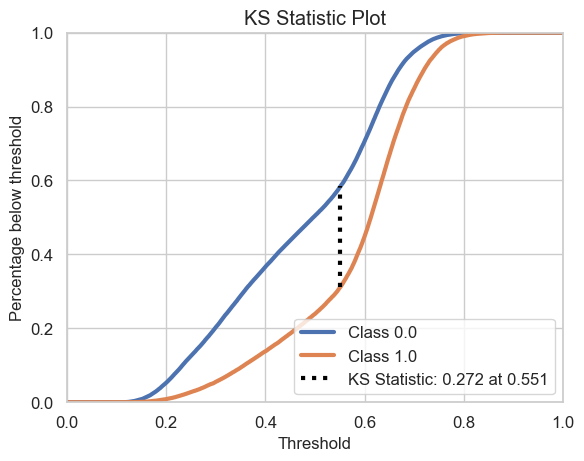

type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


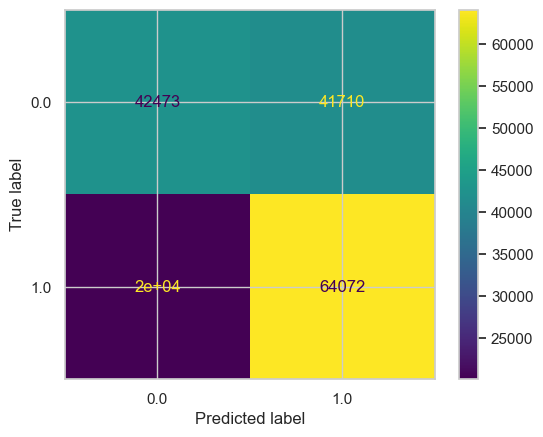


Accuracy:         0.6328
Recall:           0.7611
Precision:        0.6057
F1:               0.6746
AUROC:            0.6865
KS:               0.2844


In [134]:
testePlot(ensembled_mlp, X_val, y_val)

# Ensemble Misto

In [135]:
mlp_clf = KerasClassifier(build_fn=createMLPModel, units=128, dropout=0.0, optimizer_name= 'rmsprop', learning_rate=0.0205, batch_size = 128, epochs = 12, activation='sigmoid', callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)])

mlp_clf._estimator_type = "classifier"

gb_clf = GradientBoostingClassifier(loss=best_gb['loss'], learning_rate=best_gb['learning_rate'], n_estimators=best_gb['n_estimators'], random_state=42, verbose=3) 

rf_clf = RandomForestClassifier(n_estimators=best_rf['n_estimators'],random_state=42, n_jobs=-1, verbose=3)

ens_clf = VotingClassifier([('mlp', mlp_clf), ('gb', gb_clf), ('rf', rf_clf)], voting='soft')

ens_clf.fit(X_train, y_train)

C:\Users\User\AppData\Local\Temp\ipykernel_8820\3152088110.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  mlp_clf = KerasClassifier(build_fn=createMLPModel, units=128, dropout=0.0, optimizer_name= 'rmsprop', learning_rate=0.0205, batch_size = 128, epochs = 12, activation='sigmoid', callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)])
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array wa

Epoch 1/12
2671/2671 [==============================] - 13s 5ms/step - loss: 0.2368 - binary_accuracy: 0.6141
Epoch 2/12
2671/2671 [==============================] - 13s 5ms/step - loss: 0.2260 - binary_accuracy: 0.6316
Epoch 3/12
2671/2671 [==============================] - 13s 5ms/step - loss: 0.2255 - binary_accuracy: 0.6317
Epoch 4/12
2671/2671 [==============================] - 13s 5ms/step - loss: 0.2254 - binary_accuracy: 0.6324
Epoch 5/12
2671/2671 [==============================] - 13s 5ms/step - loss: 0.2253 - binary_accuracy: 0.6330
Epoch 6/12
2671/2671 [==============================] - 13s 5ms/step - loss: 0.2250 - binary_accuracy: 0.6345
Epoch 7/12
2671/2671 [==============================] - 13s 5ms/step - loss: 0.2252 - binary_accuracy: 0.6340
Epoch 8/12
2671/2671 [==============================] - 13s 5ms/step - loss: 0.2249 - binary_accuracy: 0.6347
Epoch 9/12
2671/2671 [==============================] - 13s 5ms/step - loss: 0.2251 - binary_accuracy: 0.6342
Epoch 10/1

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           1.3751           57.63m
         2           1.3658           57.80m
         3           1.3577           57.96m
         4           1.3508           58.17m
         5           1.3450           57.94m
         6           1.3396           57.63m
         7           1.3346           57.55m
         8           1.3304           57.35m
         9           1.3261           57.20m
        10           1.3228           57.06m
        11           1.3194           57.00m
        12           1.3164           56.85m
        13           1.3120           56.67m
        14           1.3092           56.54m
        15           1.3069           56.31m
        16           1.3048           56.05m
        17           1.3018           55.94m
        18           1.2994           55.71m
        19           1.2978           55.56m
        20           1.2962           55.38m
        21           1.2929           55.24m
        2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.4min finished


VotingClassifier(estimators=[('mlp',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001F5FCCD74F0>),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.09206820030188005,
                                                         loss='deviance',
                                                         n_estimators=400,
                                                         random_state=42,
                                                         verbose=3)),
                             ('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     n_jobs=-1, random_state=42,
                                                     verbose=3))],
                 voting='soft')

In [137]:
ensemble_clf_predict = ens_clf.predict(X_val)
ensemble_clf_predict = np.array([0 if x < 0.5 else 1 for x in ensemble_clf_predict])

ks = ks_results(reshape_plot(ensemble_clf_predict, y_val)[0], reshape_plot(ensemble_clf_predict, y_val)[1])
precision = precision_score(y_val, ensemble_clf_predict)
recall = recall_score(y_val, ensemble_clf_predict)
f1 = f1_score(y_val, ensemble_clf_predict)
roc = roc_auc_score(y_val, ensemble_clf_predict)
accuracy = accuracy_score(y_val, ensemble_clf_predict)

results_clf = pd.DataFrame({'model': 'Misto', 'ks': ks, 'roc': roc, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}, index=[0])
#results_clf = pd.DataFrame({'model': 'Misto', 'ks': ks, 'roc': roc, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})
results_ensemble = pd.concat([results_ensemble, results_clf])
results_ensemble


5262/5262 [==============================] - 7s 1ms/step


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    1.8s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    3.5s finished


type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


,model,ks,roc,accuracy,precision,recall,f1
0,MLP Ensemble,0.284354,0.632818,0.632818,0.605699,0.761104,0.674566
0,Misto,0.308095,0.653754,0.653754,0.660771,0.631933,0.646030


Gerando análises para o modelo VotingClassifier(estimators=[('mlp',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001F5FCCD74F0>),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.09206820030188005,
                                                         loss='deviance',
                                                         n_estimators=400,
                                                         random_state=42,
                                                         verbose=3)),
                             ('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     n_jobs=-1, random_state=42,
                                                     verbose=3))],
                 voting='soft')
5262/5262 [==============================] - 7s 1ms/step


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    1.9s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    3.7s finished


5262/5262 [==============================] - 7s 1ms/step


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    3.4s finished
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


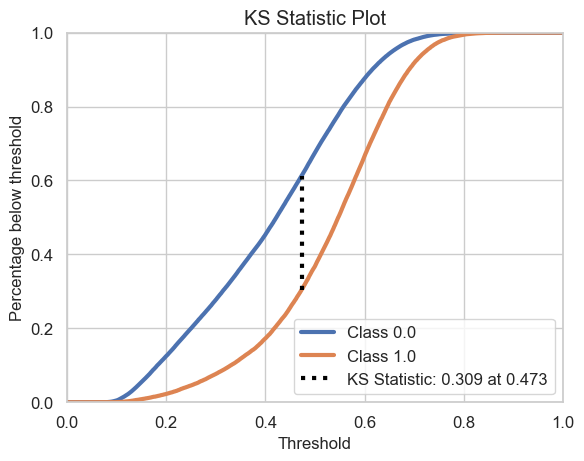

type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


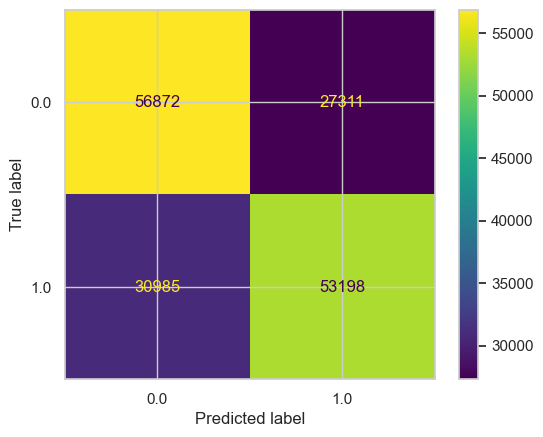


Accuracy:         0.6538
Recall:           0.6319
Precision:        0.6608
F1:               0.6460
AUROC:            0.7108
KS:               0.3081


In [138]:
testePlot(ens_clf, X_val, y_val)

# Tratando o performance no dataset de teste

In [139]:
df_test = pd.read_table('TST.cod')
df_test

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,0,1,1,1,0,0,0,0,0.898745,1,...,0,1,1,1,0,0,0,0,1,0
1,1,1,1,0,1,0,0,0,0.847404,1,...,0,0,0,1,1,1,0,0,1,0
2,2,1,1,0,0,0,0,1,0.016513,0,...,0,1,0,0,1,0,0,1,0,1
3,3,1,1,0,1,0,0,0,0.688950,0,...,0,0,0,0,0,1,0,1,1,0
4,4,0,1,1,0,0,1,0,0.230114,1,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129728,129728,1,1,0,0,1,0,0,0.144526,1,...,0,0,1,1,0,0,1,0,1,0
129729,129729,1,0,1,0,0,1,0,0.118741,0,...,1,1,1,0,0,0,1,1,1,0
129730,129730,1,0,0,1,1,0,0,0.888636,0,...,0,1,0,1,1,0,1,0,1,0
129731,129731,1,1,0,0,1,0,0,0.082791,1,...,1,0,0,1,1,0,0,0,0,1


In [140]:
df_test = df_test.drop(columns=["INDEX", "IND_BOM_1_1"])

df_test[df_test.duplicated(keep=False)]

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_6,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_2
1499,1,1,0,0,0,0,1,1.000000e+00,1,0.111111,...,1,1,0,0,1,1,0,1,0,0
2644,1,1,0,0,0,0,1,1.000000e+00,1,0.111111,...,0,1,1,0,0,1,1,0,0,0
3712,1,1,0,0,0,1,0,1.000000e+00,1,0.111111,...,0,1,1,0,0,1,0,1,1,0
8389,1,1,0,0,0,1,0,1.000000e+00,0,0.111111,...,0,0,0,0,0,1,1,0,0,0
10593,1,1,0,0,0,1,0,5.506237e-16,0,0.111111,...,1,0,0,0,0,1,1,1,0,0
15408,1,1,0,0,0,1,0,1.000000e+00,0,0.111111,...,0,0,0,0,0,1,1,0,0,0
18758,1,1,0,0,0,1,0,1.000000e+00,0,0.111111,...,1,1,0,0,0,0,1,0,1,0
25855,1,1,1,0,0,0,0,1.000000e+00,1,0.111111,...,1,1,1,1,0,0,0,1,0,0
30338,0,1,1,1,0,0,0,5.506237e-16,1,0.111111,...,0,0,0,0,1,1,1,1,0,0
33139,1,1,0,0,0,0,1,1.000000e+00,0,0.111111,...,0,0,0,0,1,1,1,0,1,0


In [141]:
normalized_test=scaler(df_test)

for i in normalized_test.columns:
  if(normalized_test[i].isnull().values.any()):
    normalized_test[i] = normalized_test[i].fillna(0)

(normalized_test >= 0).all().any()

test_numpy = normalized_test.to_numpy()
print(f'Our test data has shape: {test_numpy.shape}.')

X_test =test_numpy[:, :-1]
y_test = test_numpy[:,-1].reshape(test_numpy.shape[0],1)

X_test.shape, y_test.shape



Our test data has shape: (129733, 244).


((129733, 243), (129733, 1))

Gerando análises para o modelo RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_leaf=10,
                       n_estimators=200, n_jobs=-1, random_state=42, verbose=3)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.4s finished
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


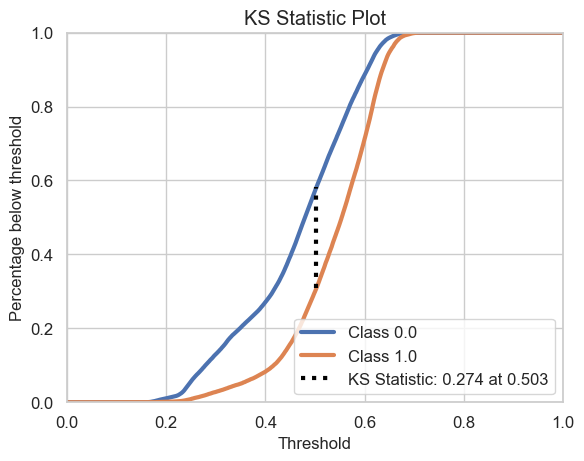

type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


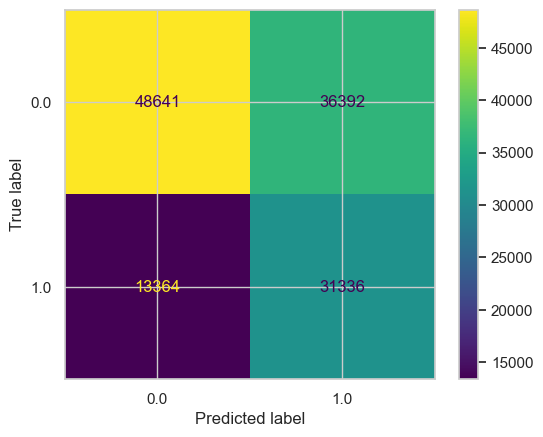


Accuracy:         0.6165
Recall:           0.7010
Precision:        0.4627
F1:               0.5574
AUROC:            0.6893
KS:               0.2471


In [142]:
testePlot(rf_opt, X_test, y_test)

In [143]:
print(model)
print(y_pred)

[[0.143978  ]
 [0.4498106 ]
 [0.6637683 ]
 ...
 [0.66831   ]
 [0.6104322 ]
 [0.74857414]]


In [144]:
gb_opt

GradientBoostingClassifier(learning_rate=0.09206820030188005, loss='deviance',
                           n_estimators=400, random_state=42, verbose=3)

Gerando análises para o modelo GradientBoostingClassifier(learning_rate=0.09206820030188005, loss='deviance',
                           n_estimators=400, random_state=42, verbose=3)


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


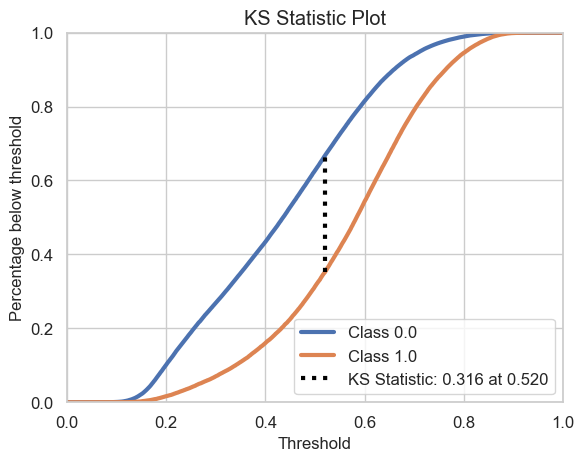

type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


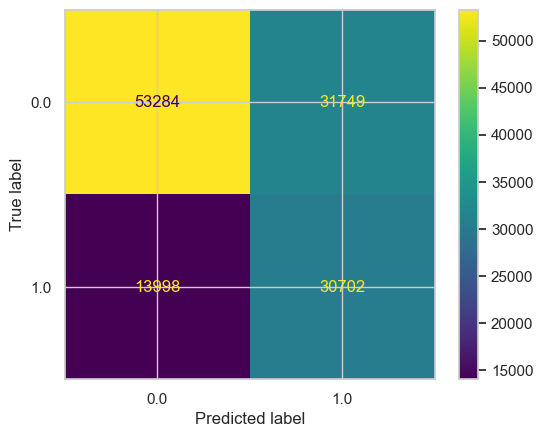


Accuracy:         0.6474
Recall:           0.6868
Precision:        0.4916
F1:               0.5731
AUROC:            0.7164
KS:               0.2836


In [153]:
testePlot(gb_opt, X_test, y_test)
# GB Arbitrário melhor que OPT


Gerando análises para o modelo VotingClassifier(estimators=[('mlp1',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001F64C53BB50>),
                             ('mlp2',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001F64C53B790>)],
                 verbose=3, voting='soft')
4055/4055 [==============================] - 5s 1ms/step


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


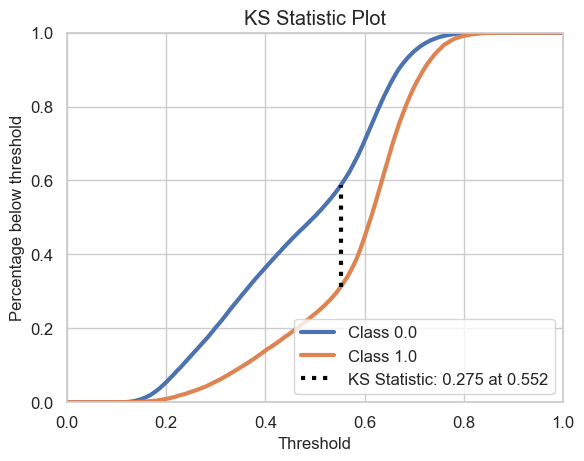

type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


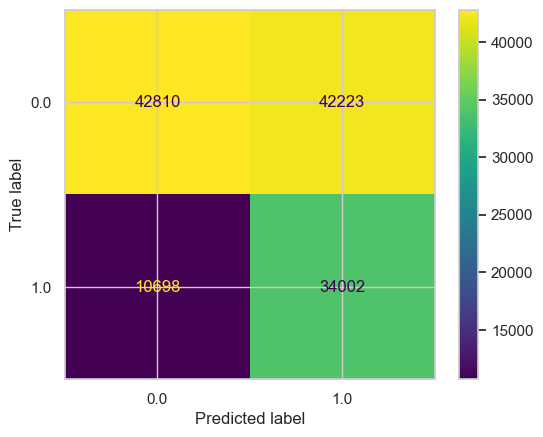


Accuracy:         0.5921
Recall:           0.7607
Precision:        0.4461
F1:               0.5624
AUROC:            0.6868
KS:               0.2461


In [146]:
testePlot(ensembled_mlp, X_test, y_test)

Gerando análises para o modelo VotingClassifier(estimators=[('mlp',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001F5FCCD74F0>),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.09206820030188005,
                                                         loss='deviance',
                                                         n_estimators=400,
                                                         random_state=42,
                                                         verbose=3)),
                             ('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     n_jobs=-1, random_state=42,
                                                     verbose=3))],
                 voting='soft')
4055/4055 [==============================] - 5s 1ms/step


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    1.4s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    2.7s finished


4055/4055 [==============================] - 6s 1ms/step


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    1.3s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    2.7s finished
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


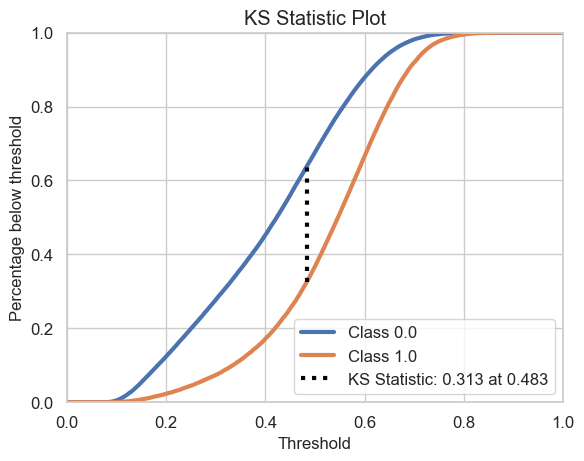

type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


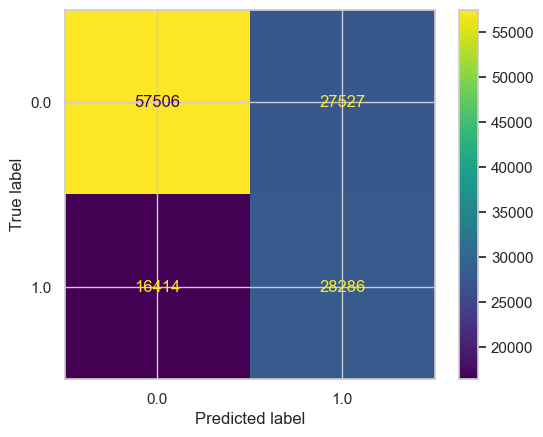


Accuracy:         0.6613
Recall:           0.6328
Precision:        0.5068
F1:               0.5628
AUROC:            0.7125
KS:               0.2847


In [157]:
testePlot(ens_clf, X_test, y_test)

Gerando análises para o modelo GradientBoostingClassifier(random_state=42, verbose=4)


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


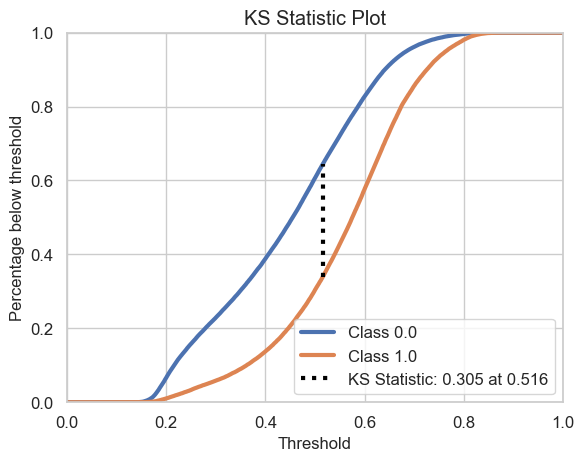

type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


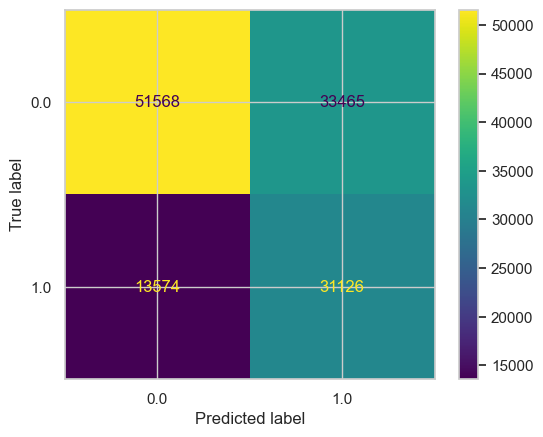


Accuracy:         0.6374
Recall:           0.6963
Precision:        0.4819
F1:               0.5696
AUROC:            0.7086
KS:               0.2735


In [155]:
testePlot(gb, X_test, y_test)

Gerando análises para o modelo <keras.engine.sequential.Sequential object at 0x000001F32D0421D0>
4055/4055 [==============================] - 6s 1ms/step
[[0.13172014]
 [0.15772587]
 [0.6210189 ]
 ...
 [0.16881187]
 [0.5738618 ]
 [0.27689072]]


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


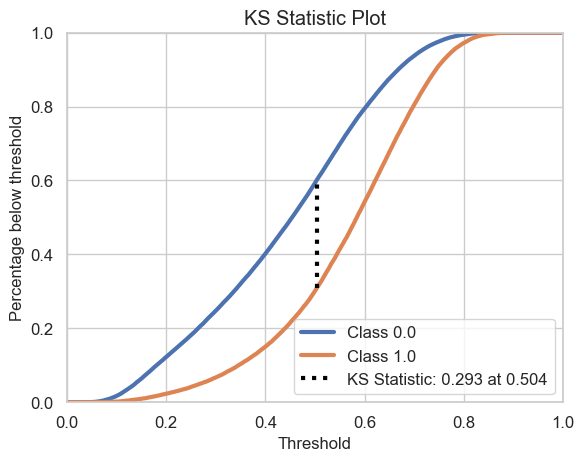

type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


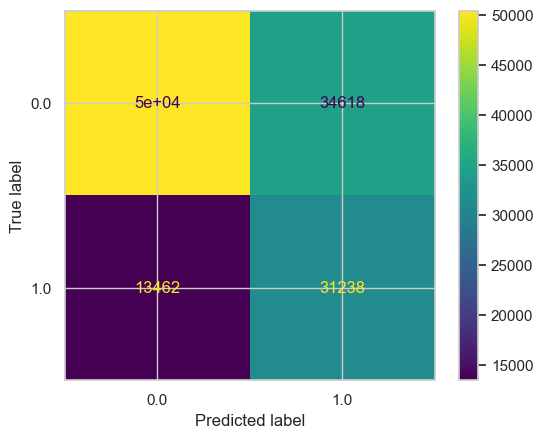


4055/4055 [==============================] - 10s 3ms/step - loss: 0.6295 - accuracy: 0.6294
Score:            [0.6295037269592285, 0.629392683506012]
Accuracy:         0.6294
Recall:           0.6988
Precision:        0.4743
F1:               0.5651
AUROC:            0.7010
KS:               0.2636


In [149]:
testePlot(mlp_opt, X_test, y_test, True)

In [150]:
results_basic

,model,ks,roc,accuracy,precision,recall,f1
0,MLP Básico,0.016749,0.493003,0.493003,0.495022,0.695817,0.578491
0,Random Forest Básico,0.213464,0.606732,0.606732,0.663286,0.433555,0.524363
0,Gradient Boosting Básico,0.302603,0.651301,0.651301,0.638741,0.696566,0.666401


In [151]:
results_ensemble

,model,ks,roc,accuracy,precision,recall,f1
0,MLP Ensemble,0.284354,0.632818,0.632818,0.605699,0.761104,0.674566
0,Misto,0.308095,0.653754,0.653754,0.660771,0.631933,0.646030


In [152]:
results_opt

,model,ks,roc_auc,accuracy,precision,recall,f1
0,MLP Optuna,0.255255,0.626676,0.626676,0.638645,0.583514,0.609836
1,MLP Optuna,0.283244,0.638336,0.638336,0.620048,0.714503,0.663933
2,MLP Optuna,0.278791,0.638318,0.638318,0.627137,0.682287,0.653551
3,MLP Optuna,0.285532,0.642630,0.642630,0.638358,0.658066,0.648062
4,MLP Optuna,0.000000,0.500000,0.500000,0.500000,1.000000,0.666667
5,MLP Optuna,0.288489,0.643818,0.643818,0.636398,0.671014,0.653248
6,MLP Optuna,0.273572,0.636292,0.636292,0.628570,0.666322,0.646896
7,MLP Optuna,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000
0,Random Forest Optuna,0.272645,0.634148,0.634148,0.619107,0.697290,0.655877
1,Random Forest Optuna,0.206013,0.594182,0.594182,0.572857,0.740530,0.645990
